In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects
import seaborn as sns
import numpy as np
import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator
import math
import os

import sys

sys.path.append('./../src/')
# from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams['pdf.fonttype'] = 42  # edit-able in illustrator
# mpl.rcParams['font.sans-serif'] = "Arial"
# mpl.rcParams["font.family"] = "sans-serif"


import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [2]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '06_covid-analysis'    # name of notebook
save = True

In [3]:
def dump_figure(name):
    if save:
        export.image(
            user,
            f'{outfolder}/{name}.pdf',
        )

In [4]:
data = pd.read_csv(
    inout.get_material_path('general/05_join_clusters_umap/05_data_umap_clusters_220908_1554.csv.gz'), 
    index_col=0)

In [5]:
# Simplify discharge
data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

# Set discharge disposition order
data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
    'Home', 
    'Rehab', 
    'SNF', 
    'LTACH',
    'Hospice', 
    'Died'
])

data = data.rename(columns={
    'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})

# Ensure order
data.sort_values(["patient", "stay", "day"], inplace=True)

In [6]:
DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]

In [7]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

# 1. Cohort description

In [9]:
print(f"Total number of patients: {data.patient.nunique()}")
print(f"Total number of ICU-days: {data.shape[0]}")

Total number of patients: 585
Total number of ICU-days: 12495


In [10]:
data.groupby("COVID_status").agg({"patient": "nunique"})

,patient
COVID_status,
False,395
True,190


In [11]:
data.groupby(["Gender", "COVID_status"]).agg({"patient": "nunique"})

patient
Gender COVID_status         
Female False             170
       True               69
Male   False             225
       True              121

In [12]:
data.groupby(["COVID_status", "Discharge_disposition"]).agg({"patient": "nunique"})

patient
COVID_status Discharge_disposition         
False        Home                        86
             Rehab                       71
             SNF                         25
             LTACH                       38
             Hospice                     19
             Died                       156
True         Home                        47
             Rehab                       26
             SNF                          8
             LTACH                       22
             Hospice                      0
             Died                        87

In [13]:
def stacked_hue_barplot(df, x, y, hue, stacks, ax, palette=None):
    if palette is None:
        palette = mpl.cm.tab10
    bar_gap = 1
    bar_width = 2
    col_pad = 2
    n_bars = len(stacks)
    n_cols = df[x].nunique()
    col_width = n_bars * bar_width + (n_bars - 1) * bar_gap + 2 * col_pad
    col_values = pd.Series(df[x].unique()).sort_values().reset_index(drop=True)
    hue_values = pd.Series(df[hue].unique()).sort_values().reset_index(drop=True)
    bar_values = pd.Series(range(len(stacks))).sort_values().reset_index(drop=True)
    to_display = pd.DataFrame(dict(
        col=np.repeat(col_values, n_bars), 
        bar=np.tile(bar_values, n_cols),
        bar_num=np.tile(bar_values.index, n_cols)
    )).reset_index().rename({"index": "col_num"}, axis=1)
    to_display["bar_pos"] = to_display.apply(
        lambda x: x.col_num * col_width + x.bar_num * bar_width + (x.bar_num - 1) * bar_gap + col_pad, 
        axis=1
    )
    max_stack = max([len(group) for group in stacks])
    bottom = np.zeros(to_display.shape[0])
    for i in range(max_stack):
        curr_stack = {j: group[-i - 1] for j, group in enumerate(stacks) if i < len(group)}
        to_display["bar_value"] = to_display.bar.map(curr_stack)
        count = to_display.merge(
            df.loc[df[hue].isin(curr_stack.values()), :], 
            left_on=["col", "bar_value"], 
            right_on=[x, hue],
            how="left"
        )[y].fillna(0)
        ax.bar(
            to_display.bar_pos, 
            count, 
            color=[palette(hue_values.index[hue_values == i]) 
                   for i in to_display.bar_value.fillna(hue_values.values[0])],
            ec="#333333",
            width=bar_width,
            align="edge",
            bottom=bottom
        )
        bottom += count
    ax.set_xticks(col_values.index * col_width + col_width / 2 + -1 * bar_gap)
    ax.set_xticklabels(col_values, size=16)
    ax.set_ylim((0, bottom.max() + bottom.max() * 0.1))

    bar_handles = []
    for i, b in enumerate(hue_values):
        bar_handles.append(mpl.patches.Patch(color=palette(i), label=b, ec="#333333"))
    ax.legend(
        handles=bar_handles, 
        loc="upper right", 
        title="Discharge disposition", 
        frameon=False,
        fontsize=14,
        title_fontsize=12
    )
    return ax

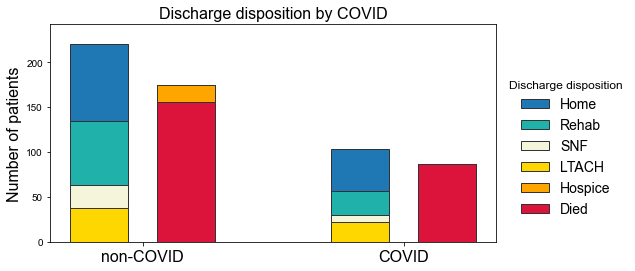

In [14]:
df = data.groupby(["COVID_status", "Discharge_disposition"]).agg({"patient": "nunique"}).reset_index()
fig, ax = plt.subplots(figsize=(8, 4))
stacked_hue_barplot(
    df=df, 
    x="COVID_status", 
    y="patient", 
    hue="Discharge_disposition", 
    stacks=DISCHARGE_STACKS,
    ax=ax, 
    palette=mpl.colors.ListedColormap(DISCH_PALETTE),
)
ax.set_ylabel("Number of patients", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Discharge disposition by COVID", size=16);

In [15]:
df.loc[df.COVID_status, "patient"] *= 100 / df.patient[df.COVID_status].sum()
df.loc[~df.COVID_status, "patient"] *= 100 / df.patient[~df.COVID_status].sum()

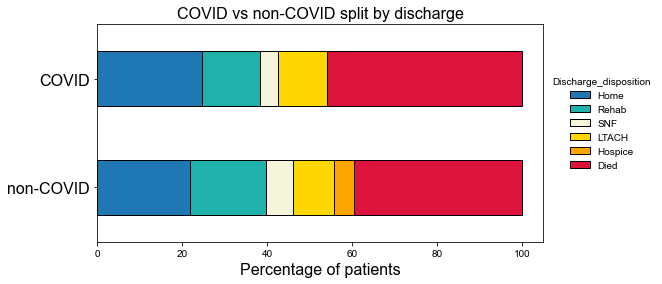

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
df.pivot_table(values="patient", index=["Discharge_disposition"], columns="COVID_status").T.plot.barh(
    stacked=True,
    ax=ax,
    cmap=mpl.colors.ListedColormap(DISCH_PALETTE),
    ec="black"
)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.legend_.set_frame_on(False)
ax.set_ylabel("")
ax.set_yticklabels(["non-COVID", "COVID"], size=16)
ax.set_xlabel("Percentage of patients", size=16)
ax.set_title("COVID vs non-COVID split by discharge", size=16);

In [17]:
df = data.groupby("patient").head(1)

In [18]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.Discharge_disposition.unique(), 2):
        days1 = df.Cumulative_ICU_days[(df.COVID_status == is_covid) & (df.Discharge_disposition == d1)]
        days2 = df.Cumulative_ICU_days[(df.COVID_status == is_covid) & (df.Discharge_disposition == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.Discharge_disposition.unique():
    days1 = df.Cumulative_ICU_days[~df.COVID_status & (df.Discharge_disposition == d)]
    days2 = df.Cumulative_ICU_days[df.COVID_status & (df.Discharge_disposition == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [19]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [20]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

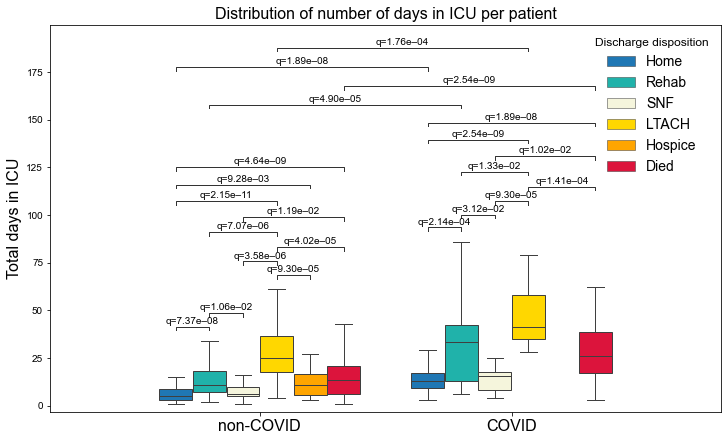

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="Cumulative_ICU_days", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1,
    showfliers=False
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Total days in ICU", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(
    loc="upper right", 
    title="Discharge disposition", 
    frameon=False, 
    fontsize=14,
    title_fontsize=12,
)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of days in ICU per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="Cumulative_ICU_days", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()
dump_figure('icu-days')

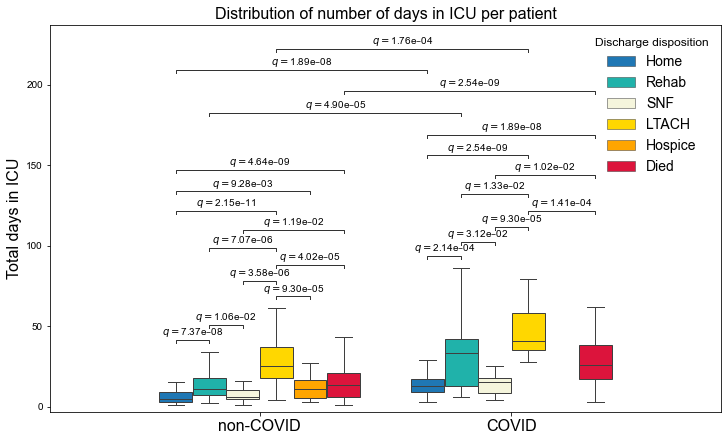

In [22]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="Cumulative_ICU_days", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1,
    showfliers=False
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Total days in ICU", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(
    loc="upper right", 
    title="Discharge disposition", 
    frameon=False, 
    fontsize=14,
    title_fontsize=12,
)
# ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of days in ICU per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="Cumulative_ICU_days", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"$q=${x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()
dump_figure('icu-days-no-outliers')


# fig.savefig("13plots/13-01icu-days-no-outliers.pdf")

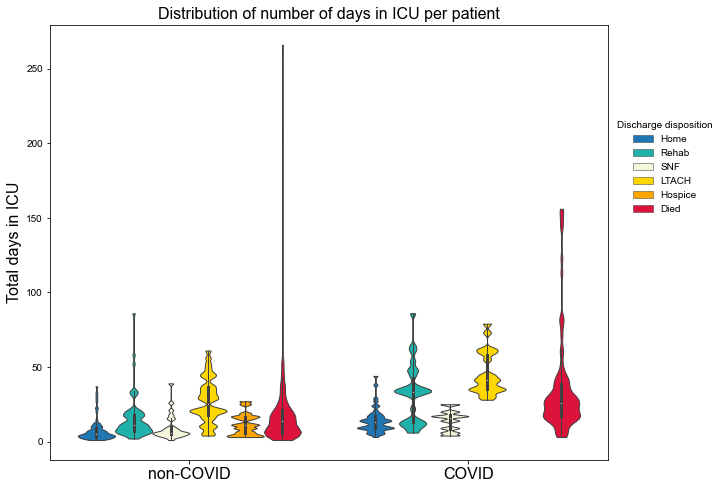

In [23]:
fig, ax = plt.subplots()
sns.violinplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="Cumulative_ICU_days", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1,
    cut=0,
    bw=0.1,
    scale="width"
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Total days in ICU", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Discharge disposition", frameon=False)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of days in ICU per patient", size=16);

# 2. Simple cluster and transition metrics

## 2.1 Number of visited unique clusters per patient

In [24]:
df = data.groupby(["COVID_status", "Discharge_disposition", "patient"]).agg(
    {"cluster": "nunique"}
).reset_index()

In [25]:
df = df.loc[df.cluster > 0, :]

In [26]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.Discharge_disposition.unique(), 2):
        days1 = df.cluster[(df.COVID_status == is_covid) & (df.Discharge_disposition == d1)]
        days2 = df.cluster[(df.COVID_status == is_covid) & (df.Discharge_disposition == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.Discharge_disposition.unique():
    days1 = df.cluster[~df.COVID_status & (df.Discharge_disposition == d)]
    days2 = df.cluster[df.COVID_status & (df.Discharge_disposition == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [27]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [28]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

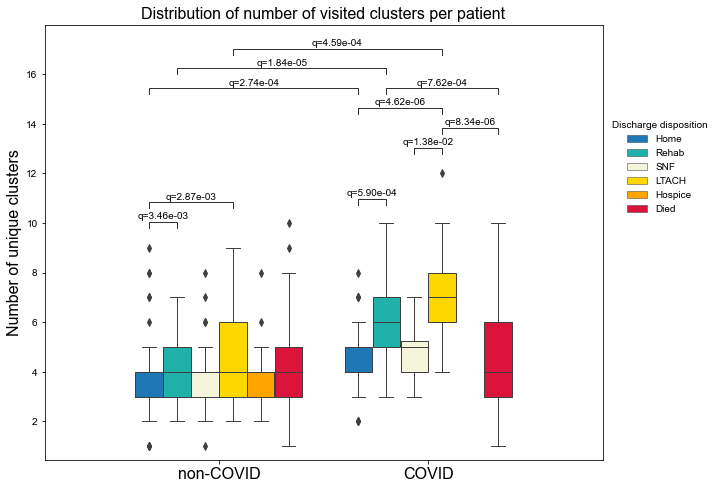

In [29]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="cluster", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Number of unique clusters", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Discharge disposition", frameon=False)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of visited clusters per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="cluster", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

## 2.2 First cluster per patient

In [30]:
def stacked_hatched_barplot(df, x, y, hue, hatch, ax, palette=None):
    if palette is None:
        palette = mpl.cm.tab10
    bar_gap = 1
    bar_width = 2
    col_pad = 3
    n_bars = df[hue].nunique()
    n_cols = df[x].nunique()
    n_hatch = df[hatch].nunique()
    hatch_cycle = ["", "////"]
    col_width = n_bars * bar_width + (n_bars - 1) * bar_gap + 2 * col_pad
    col_values = pd.Series(df[x].unique()).sort_values().reset_index(drop=True)
    bar_values = pd.Series(df[hue].unique()).sort_values().reset_index(drop=True)
    hatch_values = pd.Series(df[hatch].unique()).sort_values().reset_index(drop=True)
    to_display = pd.DataFrame(dict(
        col=np.repeat(col_values, n_bars), 
        bar=np.tile(bar_values, n_cols),
        bar_num=np.tile(bar_values.index, n_cols)
    )).reset_index().rename({"index": "col_num"}, axis=1)
    to_display["bar_pos"] = to_display.apply(
        lambda x: x.col_num * col_width + x.bar_num * bar_width + (x.bar_num - 1) * bar_gap + col_pad, 
        axis=1
    )
    bottom = np.zeros(to_display.shape[0])
    for i, h in enumerate(hatch_values):
        count = to_display.merge(
            df.loc[df[hatch] == h, :], 
            left_on=["col", "bar"], 
            right_on=[x, hue],
            how="left"
        )[y].fillna(0)
        this_h = hatch_cycle[h % len(hatch_cycle)]
        ax.bar(
            to_display.bar_pos, 
            count, 
            color=[palette(i) for i in to_display.bar_num],
            ec="#333333",
            width=bar_width,
            align="edge",
            hatch=this_h,
            bottom=bottom
        )
        bottom += count
    ax.set_xticks(col_values.index * col_width + col_width / 2)
    ax.set_xticklabels(col_values, size=16)

    bar_handles = []
    for i, b in enumerate(bar_values):
        bar_handles.append(mpl.patches.Patch(color=palette(i), label=b, ec="#333333"))
    bar_handles.append(mpl.patches.Patch(color="w", label="non-COVID", ec="#333333"))
    bar_handles.append(mpl.patches.Patch(color="w", label="COVID", ec="#333333", hatch="////"))
    ax.legend(handles=bar_handles, loc="upper right", title="Discharge disposition", frameon=False)
    return ax

In [31]:
first_days = data.groupby("patient").head(1).index

In [32]:
df = data.loc[first_days, :].groupby(["Discharge_disposition", "COVID_status"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_2": "cluster"}, axis=1)

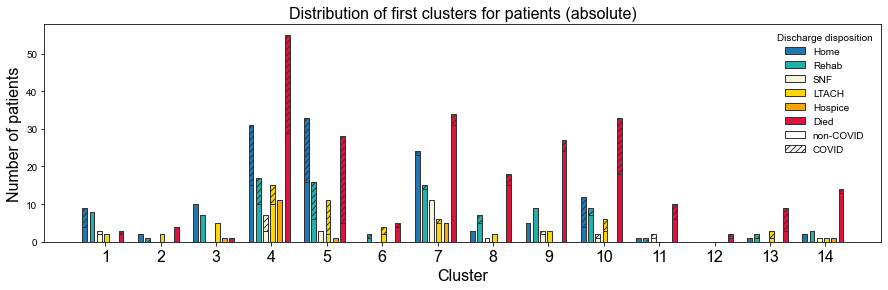

In [33]:
fig, ax = plt.subplots(figsize=(15, 4))
stacked_hatched_barplot(
    df, 
    x="cluster", 
    y="count", 
    hue="Discharge_disposition", 
    hatch="COVID_status", 
    ax=ax,
    palette=mpl.colors.ListedColormap(DISCH_PALETTE)
)
ax.legend_._loc = 1
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title("Distribution of first clusters for patients (absolute)", size=16);

In [34]:
df["count_frac"] = df["count"] / df.groupby("Discharge_disposition").agg({
    "count": "sum"
}).loc[df.Discharge_disposition, "count"].values

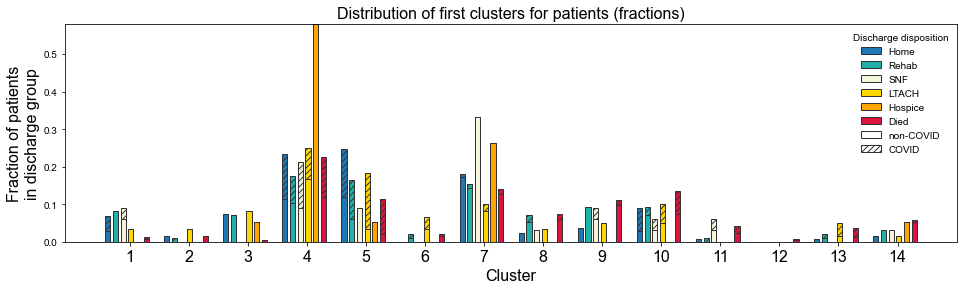

In [35]:
fig, ax = plt.subplots(figsize=(16, 4))
stacked_hatched_barplot(
    df, 
    x="cluster", 
    y="count_frac", 
    hue="Discharge_disposition", 
    hatch="COVID_status", 
    ax=ax,
    palette=mpl.colors.ListedColormap(DISCH_PALETTE)
)
ax.legend_._loc = 1
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Fraction of patients\nin discharge group", size=16)
ax.set_title("Distribution of first clusters for patients (fractions)", size=16);

In [36]:
df = data.loc[first_days, :].groupby("COVID_status").agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_2": "cluster"}, axis=1)

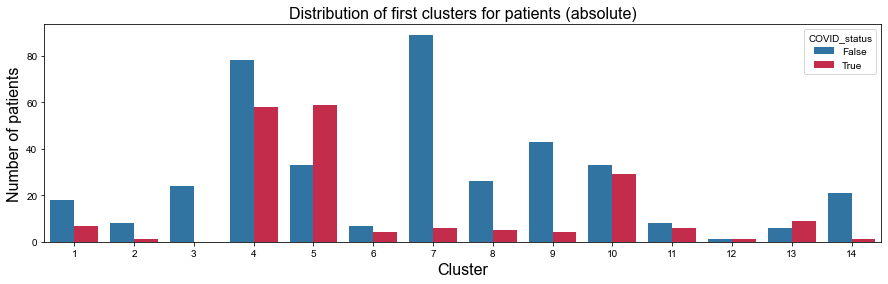

In [37]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=df, 
    x="cluster", 
    y="count", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]]
)
ax.legend_._loc = 1
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title("Distribution of first clusters for patients (absolute)", size=16);

## 2.3 First cluster for short-stay patients

In [38]:
df = data.loc[
    data.index.isin(first_days) & (data.Cumulative_ICU_days < 6), 
    :
].groupby(["Discharge_disposition", "COVID_status"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_2": "cluster"}, axis=1)

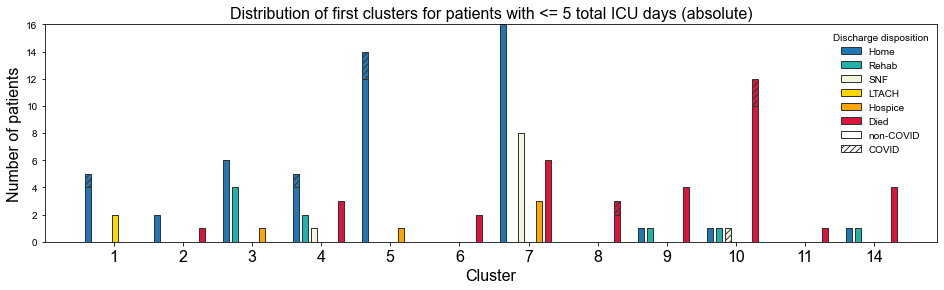

In [39]:
fig, ax = plt.subplots(figsize=(16, 4))
stacked_hatched_barplot(
    df, 
    x="cluster", 
    y="count", 
    hue="Discharge_disposition", 
    hatch="COVID_status", 
    ax=ax,
    palette=mpl.colors.ListedColormap(DISCH_PALETTE)
)
ax.legend_._loc = 1
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title("Distribution of first clusters for patients with <= 5 total ICU days (absolute)", size=16);

## 2.4 Last cluster per patient

In [40]:
last_days = data.groupby("patient").tail(1).index

In [41]:
df = data.loc[last_days, :].groupby(["Discharge_disposition", "COVID_status"]).agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_2": "cluster"}, axis=1)

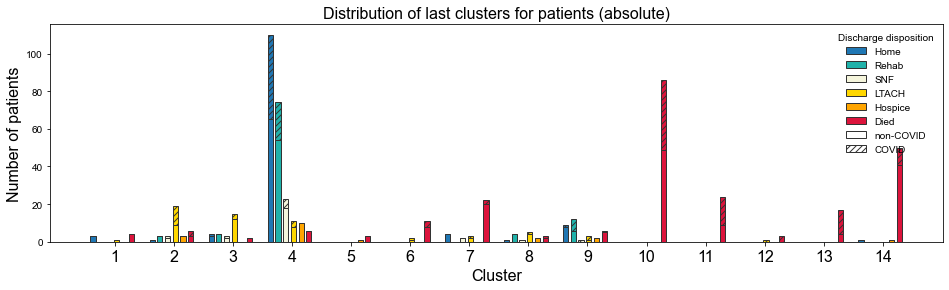

In [42]:
fig, ax = plt.subplots(figsize=(16, 4))
stacked_hatched_barplot(
    df, 
    x="cluster", 
    y="count", 
    hue="Discharge_disposition", 
    hatch="COVID_status", 
    ax=ax,
    palette=mpl.colors.ListedColormap(DISCH_PALETTE)
)
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title("Distribution of last clusters for patients (absolute)", size=16);

In [43]:
df["count_frac"] = df["count"] / df.groupby("Discharge_disposition").agg({
    "count": "sum"
}).loc[df.Discharge_disposition, "count"].values

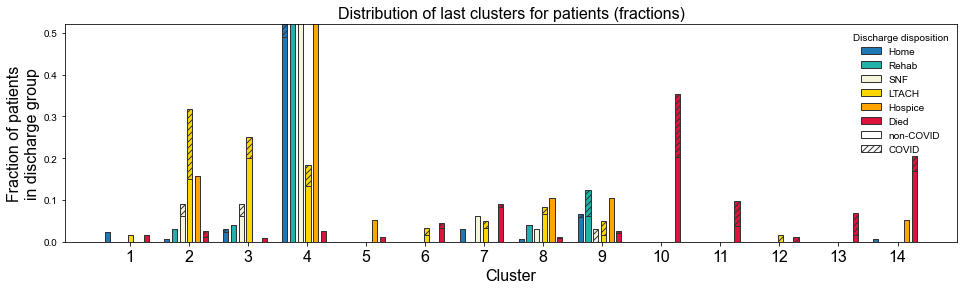

In [44]:
fig, ax = plt.subplots(figsize=(16, 4))
stacked_hatched_barplot(
    df, 
    x="cluster", 
    y="count_frac", 
    hue="Discharge_disposition", 
    hatch="COVID_status", 
    ax=ax,
    palette=mpl.colors.ListedColormap(DISCH_PALETTE)
)
ax.set_ylim(0, 0.52)
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Fraction of patients\nin discharge group", size=16)
ax.set_title("Distribution of last clusters for patients (fractions)", size=16);

In [45]:
df = data.loc[last_days, :].groupby("COVID_status").agg(
    {"cluster": "value_counts"}
).rename({"cluster": "count"}, axis=1).reset_index().rename({"level_2": "cluster"}, axis=1)

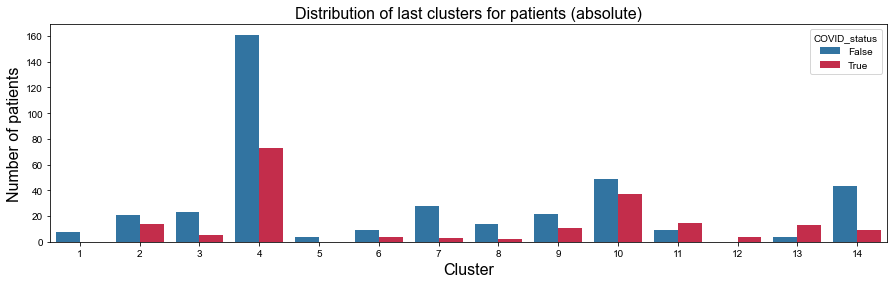

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=df, 
    x="cluster", 
    y="count", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]]
)
ax.legend_._loc = 1
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title("Distribution of last clusters for patients (absolute)", size=16);

## 2.5 Number of transitions per patient

In [47]:
df = data.groupby(["patient", "Discharge_disposition", "COVID_status", "Cumulative_ICU_days"]).apply(
    lambda x: x.is_transition.sum()
).reset_index()
df.rename({0: "is_transition"}, axis=1, inplace=True)

In [48]:
df.is_transition.value_counts()

2     96
3     88
4     82
5     53
1     49
6     38
9     26
7     25
8     25
12    18
11    15
0     15
10    12
13    12
14     6
15     6
16     5
25     4
17     3
21     2
23     2
19     1
24     1
20     1
Name: is_transition, dtype: int64

In [49]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.Discharge_disposition.unique(), 2):
        days1 = df.is_transition[(df.COVID_status == is_covid) & (df.Discharge_disposition == d1)]
        days2 = df.is_transition[(df.COVID_status == is_covid) & (df.Discharge_disposition == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.Discharge_disposition.unique():
    days1 = df.is_transition[~df.COVID_status & (df.Discharge_disposition == d)]
    days2 = df.is_transition[df.COVID_status & (df.Discharge_disposition == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [50]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [51]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

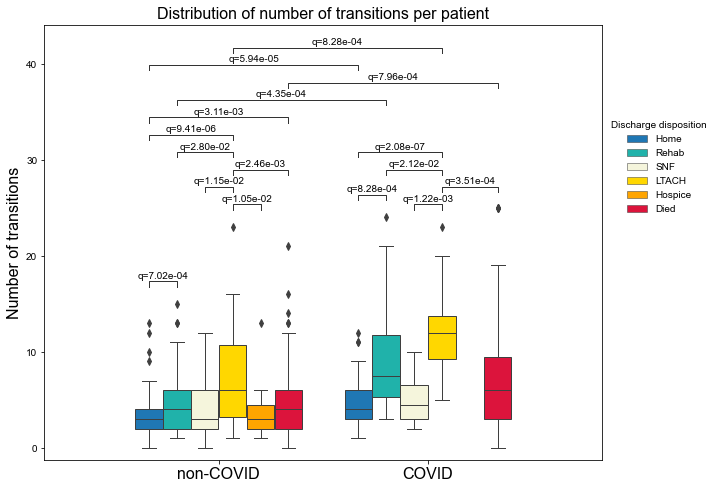

In [52]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="is_transition", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Number of transitions", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Discharge disposition", frameon=False)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of transitions per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="is_transition", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

In [53]:
df["outcome"] = "Lived"
df.loc[df.Discharge_disposition.isin(["Hospice", "Died"]), "outcome"] = "Died"

In [54]:
df.is_transition.isna().sum()

0

In [55]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.outcome.unique(), 2):
        days1 = df.is_transition[(df.COVID_status == is_covid) & (df.outcome == d1)]
        days2 = df.is_transition[(df.COVID_status == is_covid) & (df.outcome == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.outcome.unique():
    days1 = df.is_transition[~df.COVID_status & (df.outcome == d)]
    days2 = df.is_transition[df.COVID_status & (df.outcome == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [56]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [57]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

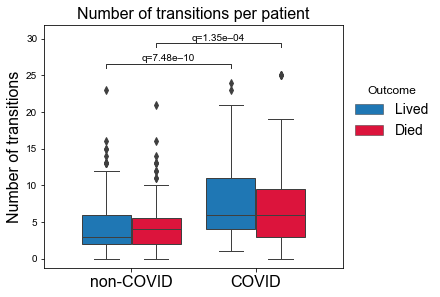

In [58]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="is_transition", 
    ax=ax, 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    linewidth=1,
    showfliers=True
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Number of transitions", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Number of transitions per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="is_transition", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()

dump_figure('transitions-binary')
# fig.savefig("13plots/13-02n-transitions-binary.pdf")

## 2.6 Number of normalized transitions

Let's normalize number of transitions by total number of ICU days per patient

In [59]:
df.is_transition /= df.Cumulative_ICU_days

In [60]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.Discharge_disposition.unique(), 2):
        days1 = df.is_transition[(df.COVID_status == is_covid) & (df.Discharge_disposition == d1)]
        days2 = df.is_transition[(df.COVID_status == is_covid) & (df.Discharge_disposition == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.Discharge_disposition.unique():
    days1 = df.is_transition[~df.COVID_status & (df.Discharge_disposition == d)]
    days2 = df.is_transition[df.COVID_status & (df.Discharge_disposition == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [61]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [62]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

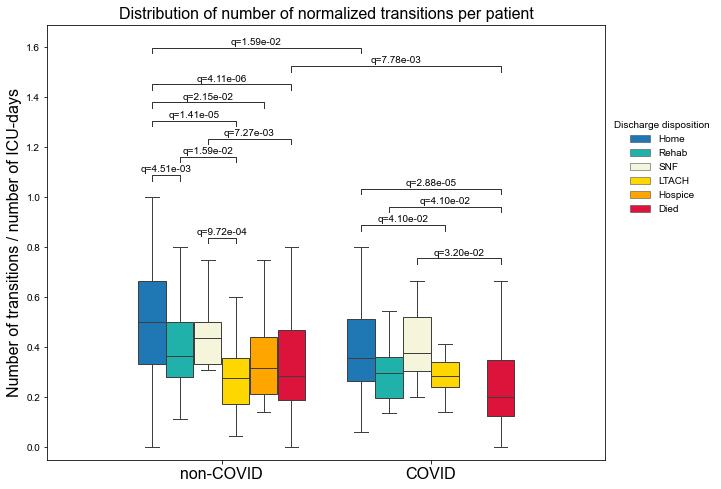

In [63]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="is_transition", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1,
    showfliers=False
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Number of transitions / number of ICU-days", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Discharge disposition", frameon=False)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Distribution of number of normalized transitions per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="is_transition", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

In [64]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.outcome.unique(), 2):
        days1 = df.is_transition[(df.COVID_status == is_covid) & (df.outcome == d1)]
        days2 = df.is_transition[(df.COVID_status == is_covid) & (df.outcome == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.outcome.unique():
    days1 = df.is_transition[~df.COVID_status & (df.outcome == d)]
    days2 = df.is_transition[df.COVID_status & (df.outcome == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [65]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [66]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

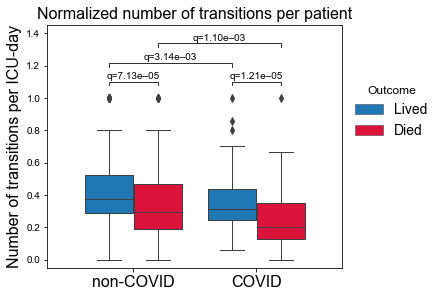

In [67]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="is_transition", 
    ax=ax, 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    linewidth=1,
    showfliers=True
)
for a in ax.collections:
    if isinstance(a, mpl.collections.PatchCollection):
        # remove line surround each box
        a.set_linewidth(0)
ax.set_ylabel("Number of transitions per ICU-day", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Outcome", frameon=False, fontsize=14, title_fontsize=12)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.set_title("Normalized number of transitions per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="is_transition", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()
dump_figure('norm-transitions-binary')


## 2.7 Favorable and unfavorable transitions

In [68]:
print(f"Total number of transitions: {(data.is_transition & (data.next_cluster != -1)).sum()}")

Total number of transitions: 3148


Let's compute cluster mortality by taking clusters for last days of the patients and computing number of expired patients divided by total number of patients in cluster.

Favourable transition is one where next cluster has less mortality.

In [69]:
df = data.loc[data.is_transition, :].copy()

In [70]:
cluster_mortality = data.copy()
cluster_mortality = cluster_mortality.groupby("cluster").apply(
    lambda x: pd.Series([x.patient.nunique(), x.patient[x.Binary_outcome.eq("Died")].nunique()])
)
cluster_mortality.rename({0: "Total", 1: "Died"}, axis=1, inplace=True)
cluster_mortality["mortality"] = cluster_mortality.Died / cluster_mortality.Total
cluster_mortality = cluster_mortality.sort_values("mortality").reset_index()

In [71]:
cluster_mortality.set_index("cluster", inplace=True)

In [72]:
df["cluster_mortality"] = cluster_mortality.mortality[df.cluster].values

In [73]:
df["next_cluster_mortality"] = cluster_mortality.mortality[df.next_cluster].values

In [74]:
df["favorable_transition"] = df.next_cluster_mortality < df.cluster_mortality

Positive is bad: increasing mortality

In [75]:
df["mortality_change"] = df.next_cluster_mortality - df.cluster_mortality

In [76]:
df.groupby(["COVID_status", "favorable_transition"]).count()[["day"]]

day
COVID_status favorable_transition     
False        False                 891
             True                  849
True         False                 764
             True                  644

In [77]:
cluster_mortality.sort_values("mortality")

,Total,Died,mortality
cluster,,,
1,204,45,0.220588
2,135,30,0.222222
3,226,57,0.252212
4,352,100,0.284091
5,208,76,0.365385
6,122,47,0.385246
7,333,146,0.438438
8,106,51,0.481132
9,126,69,0.547619


In [78]:
data.loc[df.index, "favorable_transition"] = df.favorable_transition
data.loc[df.index, "mortality_change"] = df.mortality_change

In [79]:
# data.to_csv("../2021-12-09-v4-data/20data-v1.csv.gz")

In [80]:
df = data.groupby(["patient", "Discharge_disposition", "COVID_status"]).apply(
    lambda x: pd.Series(
        [
            x.favorable_transition.dropna().astype(bool).sum(), 
            (~x.favorable_transition.dropna().astype(bool)).sum()
        ],
        index=[True, False]
    )
).reset_index().dropna().melt(
    id_vars=["patient", "Discharge_disposition", "COVID_status"],
    var_name="favorable_transition",
    value_name="n_transitions"
)

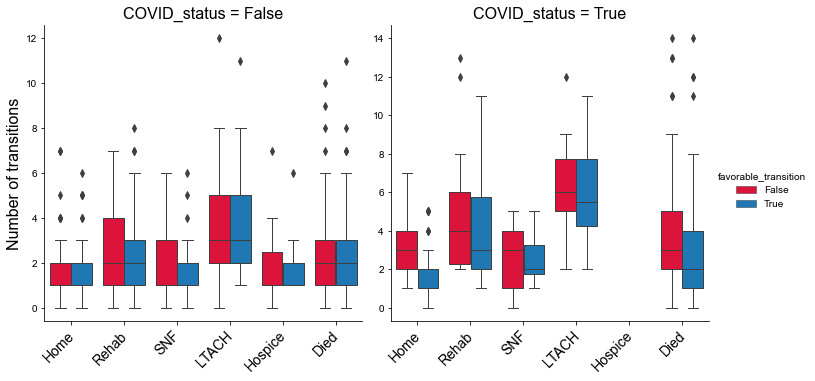

In [81]:
fg = sns.catplot(
    kind="box",
    col="COVID_status",
    data=df, 
    x="Discharge_disposition", 
    hue="favorable_transition",
    y="n_transitions", 
    saturation=1, 
    palette=[DISCH_PALETTE[-1], DISCH_PALETTE[0]],
    linewidth=1,
    sharey=False
)
fg.axes[0, 0].set_ylabel("Number of transitions", size=16)
for ax in fg.axes.ravel():
    ax.set_xlabel("")
    ax.title.set_size(16)
    trans = mpl.transforms.Affine2D().translate(6, 0)
    for t in ax.get_xticklabels():
        t.set_rotation(45)
        t.set_horizontalalignment("right")
        t.set_transform(t.get_transform() + trans)
        t.set_size(14)

In [82]:
df = data.groupby(["patient", "Discharge_disposition", "COVID_status"]).apply(
    lambda x: x.mortality_change.sum()
).reset_index()
df.rename({0: "mortality_change"}, axis=1, inplace=True)

In [83]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.Discharge_disposition.unique(), 2):
        days1 = df.mortality_change[(df.COVID_status == is_covid) & (df.Discharge_disposition == d1)]
        days2 = df.mortality_change[(df.COVID_status == is_covid) & (df.Discharge_disposition == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.Discharge_disposition.unique():
    days1 = df.mortality_change[~df.COVID_status & (df.Discharge_disposition == d)]
    days2 = df.mortality_change[df.COVID_status & (df.Discharge_disposition == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [84]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [85]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

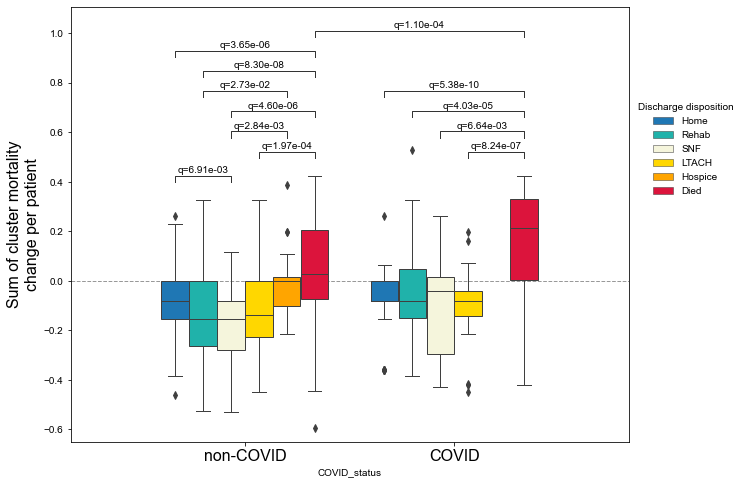

In [86]:
fig, ax = plt.subplots()
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="mortality_change", 
    ax=ax, 
    saturation=1, 
    palette=DISCH_PALETTE,
    linewidth=1,
)
ax.set_ylabel("Sum of cluster mortality\nchange per patient", size=16)
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Discharge disposition", frameon=False)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.axhline(c="#999", ls="--", lw=1, zorder=-1)
# ax.set_title("Distribution of number of transitions per patient", size=16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="Discharge_disposition", 
    y="mortality_change", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

In [87]:
df["outcome"] = "Positive"
df.loc[df.Discharge_disposition.isin(["Hospice", "Died"]), "outcome"] = "Negative"

In [88]:
stat_results = []
for is_covid in [True, False]:
    for d1, d2 in itertools.combinations(df.outcome.unique(), 2):
        days1 = df.mortality_change[(df.COVID_status == is_covid) & (df.outcome == d1)]
        days2 = df.mortality_change[(df.COVID_status == is_covid) & (df.outcome == d2)]
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stat_results.append(["COVID_status", is_covid, d1, d2, days1.size, days2.size, pval])
for d in df.outcome.unique():
    days1 = df.mortality_change[~df.COVID_status & (df.outcome == d)]
    days2 = df.mortality_change[df.COVID_status & (df.outcome == d)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["discharge", d, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [89]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [90]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "COVID_status":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

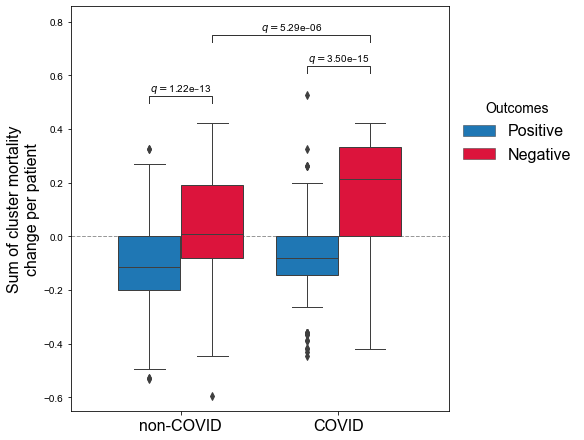

In [91]:
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="mortality_change", 
    ax=ax, 
    saturation=1, 
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    linewidth=1,
)
ax.set_ylabel("Sum of cluster mortality\nchange per patient", size=16)
ax.set_xlabel("")
ax.set_xticklabels(["non-COVID", "COVID"], size=16)
ax.legend(loc="upper left", title="Outcomes", frameon=False, fontsize=16, title_fontsize=14)
ax.legend_.set_bbox_to_anchor((1, 0.8))
ax.axhline(c="#999", ls="--", lw=1, zorder=-1)
for t in ax.get_xticklabels():
    t.set_size(16)
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="COVID_status",
    hue="outcome", 
    y="mortality_change", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"$q=${x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()

dump_figure('sum-of-transitions')
# fig.savefig("13plots/13-04sum-of-transitions.pdf")

## 2.8 Number of days spent in cluster

In [8]:
pt_lengths = data.groupby(["patient"]).agg({"day": "count"})

In [9]:
df = data.groupby(["patient", "Discharge_disposition", "COVID_status", "cluster"]).apply(
    lambda x: x.day.shape[0]
).reset_index()
df.rename({0: "n_days"}, axis=1, inplace=True)

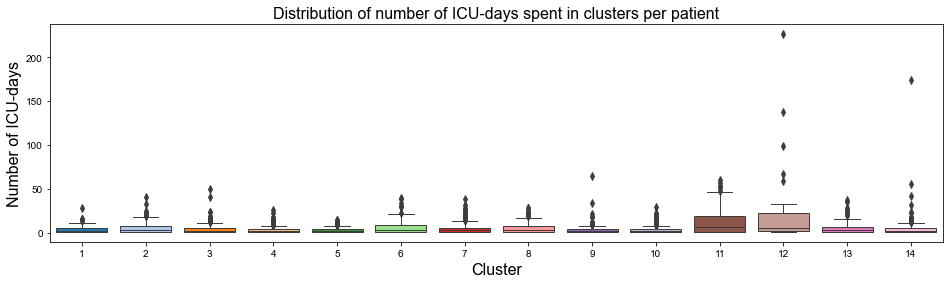

In [10]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    ax=ax,
    palette="tab20",
    saturation=1,
    linewidth=1
)
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Number of ICU-days", size=16)
ax.set_title("Distribution of number of ICU-days spent in clusters per patient", size=16);

In [11]:
stat_results = []
for c in df.cluster.unique():
    days1 = df.n_days[~df.COVID_status & (df.cluster == c)]
    days2 = df.n_days[df.COVID_status & (df.cluster == c)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["cluster", c, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [12]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]
stat_results_sign

,variable,value,group1,group2,group1_size,group2_size,pval,pval_adj
0,cluster,3,False,True,168,58,2.834774e-03,0.006614
2,cluster,5,False,True,79,129,1.264980e-04,0.000354
4,cluster,10,False,True,132,115,3.983523e-07,0.000002
5,cluster,11,False,True,47,51,1.099036e-05,0.000038
6,cluster,1,False,True,115,89,1.624799e-07,0.000002
9,cluster,13,False,True,35,80,5.631732e-03,0.011263
12,cluster,2,False,True,83,52,4.271449e-07,0.000002


In [13]:
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append(((r.value, r.group1), (r.value, r.group2)))

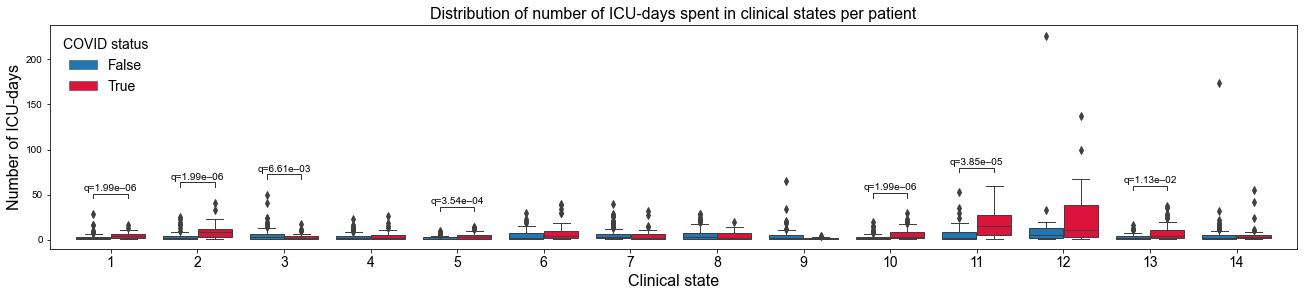

In [14]:
fig, ax = plt.subplots(figsize=(18, 4), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    labels, 
    title="COVID status", 
    fontsize=14, 
    title_fontsize=14, 
    frameon=False,
    loc="upper left"
)
ax.tick_params(axis="x", labelsize=14)
ax.set_xlabel("Clinical state", size=16)
ax.set_ylabel("Number of ICU-days", size=16)
ax.set_title("Distribution of number of ICU-days spent in clinical states per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()

dump_figure('n-days-per-cluster')



# fig.savefig("13plots/13-05n-days-per-cluster.pdf")

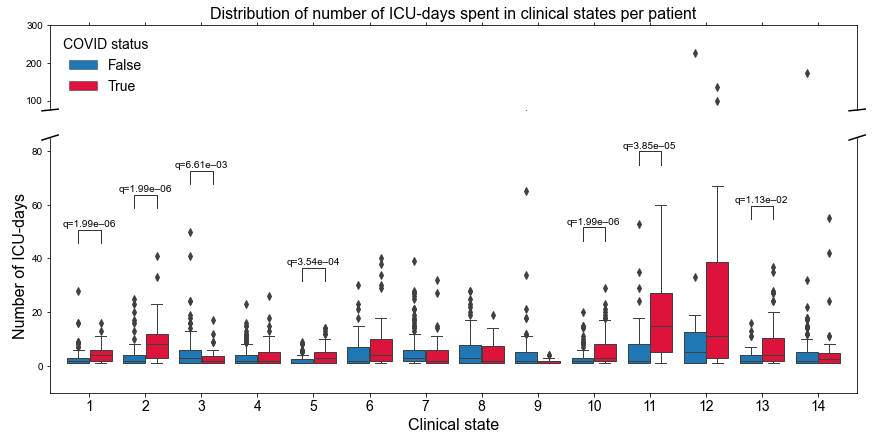

In [60]:
# tutorial https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/broken_axis.html

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12, 6),  gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)

ax=sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1
)

ax2=sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status", 
    ax=ax2,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1
)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    labels, 
    title="COVID status", 
    fontsize=14, 
    title_fontsize=14, 
    frameon=False,
    loc="upper left"
)
ax2.get_legend().remove()

ax.set_xlabel(" ", size=16)
ax.set_ylabel(" ", size=16)
ax2.tick_params(axis="x", labelsize=14)
ax2.set_xlabel("Clinical state", size=16)
ax2.set_ylabel("Number of ICU-days", size=16)
ax.set_title("Distribution of number of ICU-days spent in clinical states per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax2, 
    pairs, 
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()


ax.set_ylim(75, 300)  # outliers only
ax2.set_ylim(-10, 85)  # most of the data

dump_figure('n-days-per-cluster_split')



# fig.savefig("13plots/13-05n-days-per-cluster.pdf")

In [46]:
statannotations.__version__

'0.4.4'

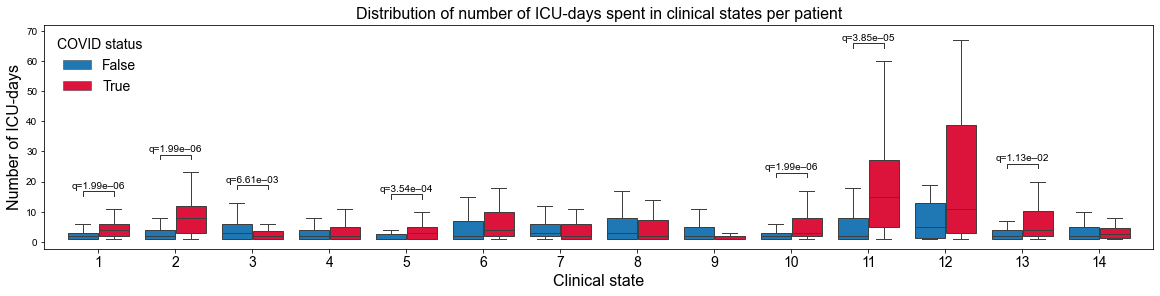

In [15]:
fig, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
sns.boxplot(
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1,
    showfliers=False
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    labels, 
    title="COVID status", 
    fontsize=14, 
    title_fontsize=14, 
    frameon=False,
    loc="upper left"
)
ax.tick_params(axis="x", labelsize=14)
ax.set_xlabel("Clinical state", size=16)
ax.set_ylabel("Number of ICU-days", size=16)
ax.set_title("Distribution of number of ICU-days spent in clinical states per patient", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="cluster", 
    y="n_days", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}".replace("-", "–") for x in stat_results_sign.pval_adj])
annotator.annotate()

dump_figure('n-days-per-cluster-no-outliers')


# fig.savefig("13plots/13-05n-days-per-cluster-no-outliers.pdf")

## 2.9 Relative number of days spent in cluster

In [100]:
df.n_days /= pt_lengths.day[df.patient].values

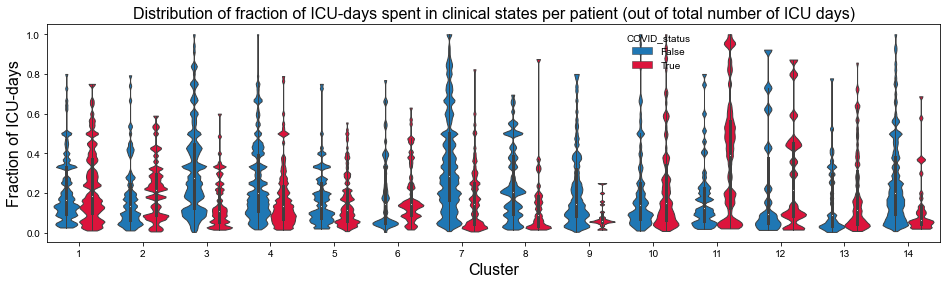

In [101]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(
    data=df, 
    x="cluster",
    hue="COVID_status", 
    y="n_days", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1,
    cut=0,
    bw=0.05,
    scale="width"
)
ax.legend_._loc = 9
ax.legend_.set_bbox_to_anchor((0.685, 1))
ax.legend_.set_frame_on(False)
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("Fraction of ICU-days", size=16)
ax.set_title(
    "Distribution of fraction of ICU-days spent in clinical states per patient (out of total number of ICU days)", 
    size=16
);

## 2.10 Relative timepoint per cluster

At which timepoint during ICU stay was a patient in a cluster? Closer to the beginning of the stay or to the end?

In [102]:
icu_rank_lengths = data.groupby(["patient", "stay"]).agg({"day": "max"})

In [103]:
df = data.copy()

In [104]:
df.day /= icu_rank_lengths.day[pd.MultiIndex.from_arrays([data.patient, data.stay])].values

In [105]:
stat_results = []
for c in df.cluster.unique():
    days1 = df.day[~df.COVID_status & (df.cluster == c)]
    days2 = df.day[df.COVID_status & (df.cluster == c)]
    if days1.size == 0 or days2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
    stat_results.append(["cluster", c, False, True, days1.size, days2.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [106]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [107]:
pairs = []
for _, r in stat_results_sign.iterrows():
    pairs.append(((r.value, r.group1), (r.value, r.group2)))

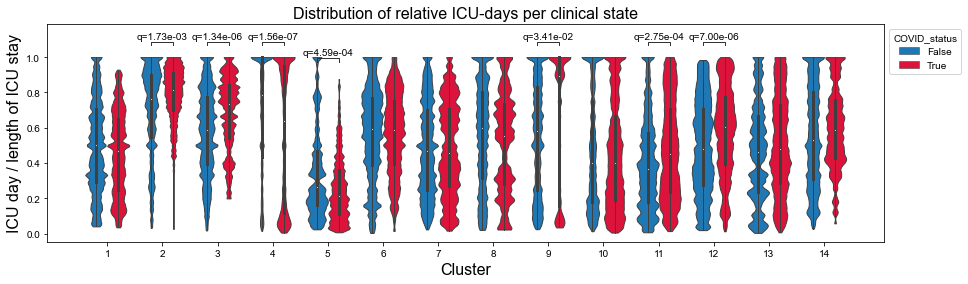

In [108]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.violinplot(
    data=df, 
    x="cluster", 
    hue="COVID_status",
    y="day", 
    ax=ax,
    palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
    saturation=1,
    linewidth=1,
    cut=0,
    bw=0.05,
    scale="width"
)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))
ax.set_xlabel("Cluster", size=16)
ax.set_ylabel("ICU day / length of ICU stay", size=16)
ax.set_title("Distribution of relative ICU-days per clinical state", size=16);
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=df, 
    x="cluster", 
    y="day", 
    hue="COVID_status",
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

## 2.11 Number of BALs per cluster

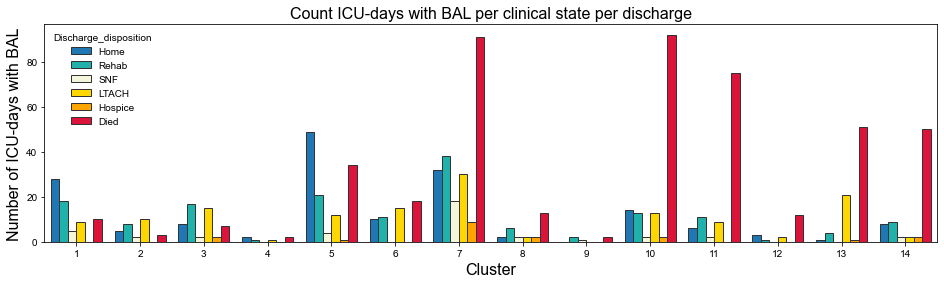

In [109]:
fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.countplot(
    data=data.loc[data.has_bal, :],
    x="cluster",
    hue="Discharge_disposition",
    ax=ax,
    palette=DISCH_PALETTE,
    saturation=1,
    ec="#333333"
)
ax.legend_.set_frame_on(False)
ax.legend_._loc = 2
ax.set_ylabel("Number of ICU-days with BAL", size=16)
ax.set_xlabel("Cluster", size=16)
ax.set_title("Count ICU-days with BAL per clinical state per discharge", size=16);

# 3. Cluster transitions analysis

## 3.1 Barplots per cluster

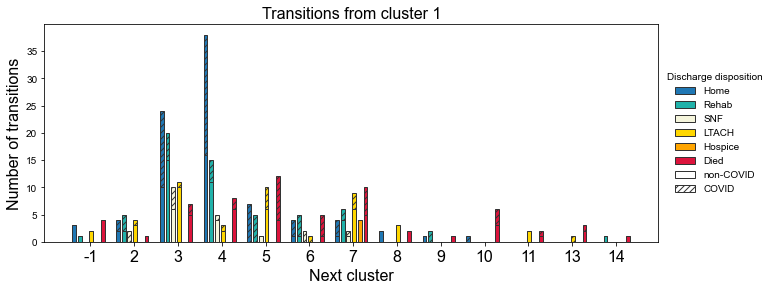

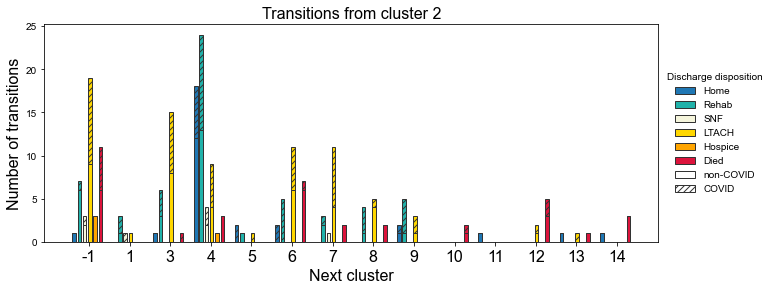

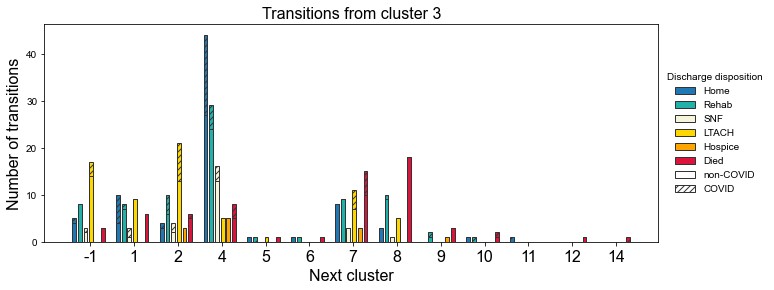

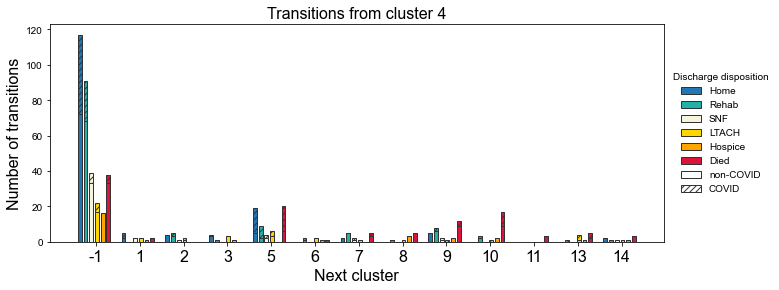

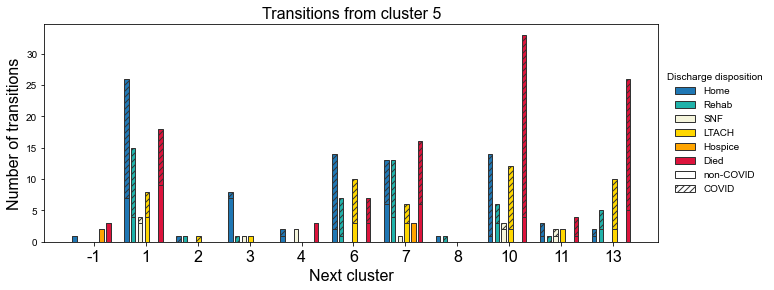

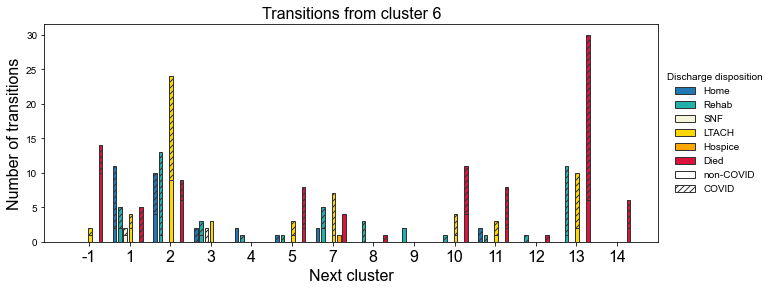

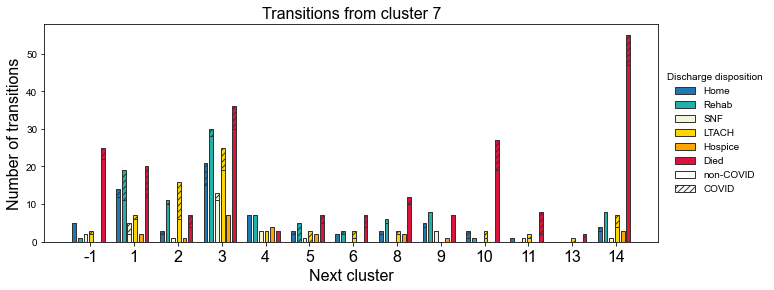

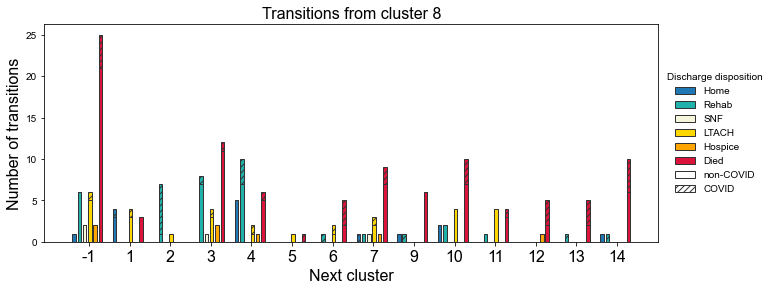

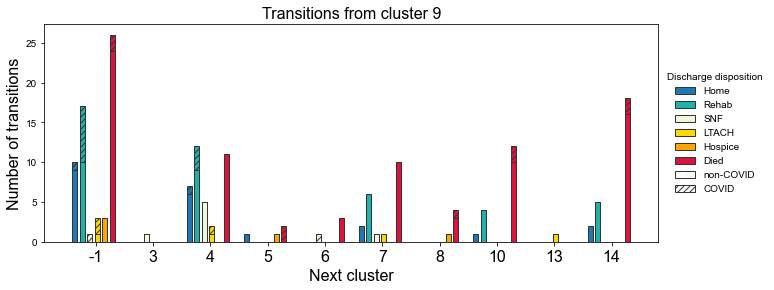

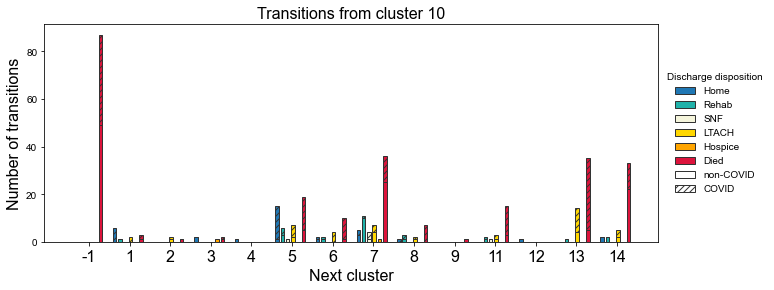

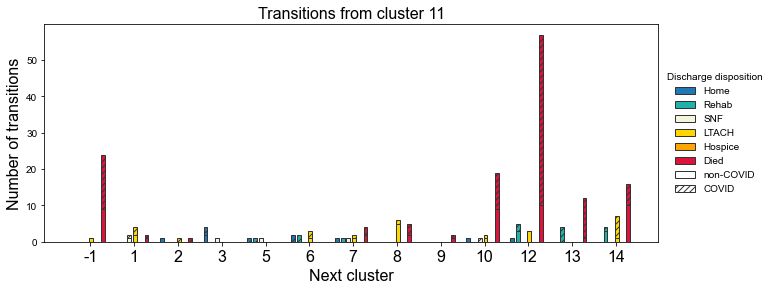

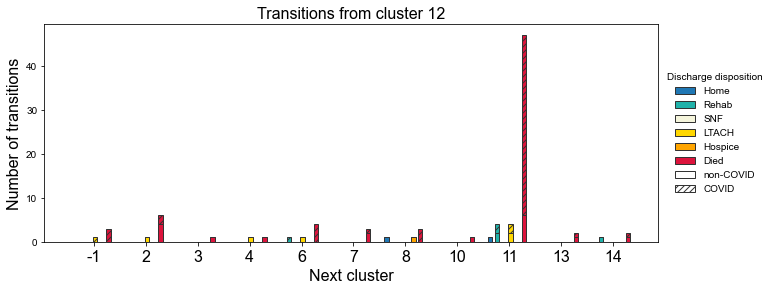

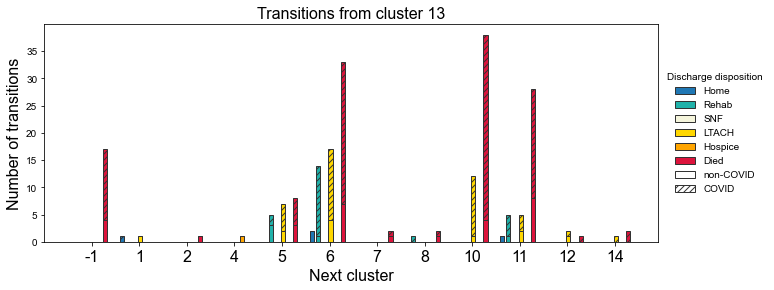

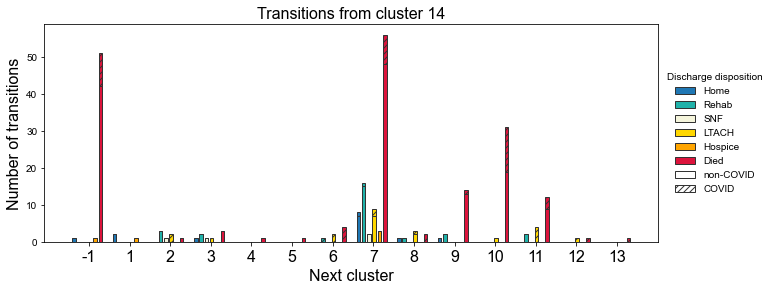

In [110]:
for c in sorted(data.cluster.unique()):
    idx = (data.cluster == c) & (data.next_cluster != c)
    fig, ax = plt.subplots(figsize=(11, 4))
    df = data.loc[idx, :].groupby(["next_cluster", "Discharge_disposition", "COVID_status"]).agg(
        {"day": "count"}
    ).reset_index()
    df = df.loc[df.next_cluster != c, :]
    stacked_hatched_barplot(
        df=df,
        x="next_cluster",
        y="day",
        hue="Discharge_disposition",
        hatch="COVID_status",
        ax=ax,
        palette=mpl.colors.ListedColormap(DISCH_PALETTE),
    )
    ax.legend_.set_frame_on(False)
    ax.legend_._loc = 6
    ax.legend_.set_bbox_to_anchor((1, 0.5))
    ax.set_title(f"Transitions from cluster {c}", size=16)
    ax.set_ylabel("Number of transitions", size=16)
    ax.set_xlabel("Next cluster", size=16)
    plt.show()

## 3.2 Summary with ball-of-yarn

In [111]:
def get_axes_pixel_transform(ax):
    t = ax.transAxes.transform([(0, 0), (1, 1)])
    return mpl.transforms.Affine2D().scale(1 / (t[1, 0] - t[0, 0]), 1 / (t[1, 1] - t[0, 1])) + ax.transAxes

In [112]:
def get_arrow_path(ax, tx, p0, i0, i1, p1, base_w=10):
    def get_dist(p0, p1):
        return ((p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2) ** 0.5
    base_h = 3
    head_w = 5
    head_h = 5
    points = np.array([p0, i0, i1, p1], dtype=float)
    (p0, i0, i1, p1) = tx.inverted().transform(ax.transData.transform(points))
    base_off = base_w / get_dist(p0, i0)
    base_hoff = base_h / get_dist(p0, i0)
    base_r = (p0[0] + base_off * (i0[1] - p0[1]), p0[1] - base_off * (i0[0] - p0[0]))
    base_m = (p0[0] + base_hoff * (i0[0] - p0[0]), p0[1] + base_hoff * (i0[1] - p0[1]))
    base_l = (p0[0] - base_off * (i0[1] - p0[1]), p0[1] + base_off * (i0[0] - p0[0]))
    head_off = head_w / get_dist(i1, p1)
    head_hoff = head_h / get_dist(i1, p1)
    head_r = (p1[0] + head_off * (p1[1] - i1[1]), p1[1] - head_off * (p1[0] - i1[0]))
    head_l = (p1[0] - head_off * (p1[1] - i1[1]), p1[1] + head_off * (p1[0] - i1[0]))
    head_r = (head_r[0] - head_hoff * (p1[0] - i1[0]), head_r[1] - head_hoff * (p1[1] - i1[1]))
    head_l = (head_l[0] - head_hoff * (p1[0] - i1[0]), head_l[1] - head_hoff * (p1[1] - i1[1]))
    verts = [base_r, i0, i1, p1, head_r, p1, head_l, p1, i1, i0, base_l, base_m, base_r]
    codes = [
        mpl.path.Path.MOVETO, mpl.path.Path.CURVE4, mpl.path.Path.CURVE4, mpl.path.Path.LINETO, 
        mpl.path.Path.LINETO, mpl.path.Path.LINETO, mpl.path.Path.LINETO, mpl.path.Path.LINETO, 
        mpl.path.Path.CURVE4, mpl.path.Path.CURVE4, mpl.path.Path.LINETO, mpl.path.Path.LINETO,
        mpl.path.Path.CLOSEPOLY
    ]
    return mpl.path.Path(verts, codes)

In [113]:
def reorder_df(df, curr_cl, idx):
    cur_idx = idx.get_loc(curr_cl)
    idx = pd.Series(np.roll(idx, 5 - cur_idx))
    idx[:5] = list(reversed(idx[:5]))
    idx[6:] = list(reversed(idx[6:].values))
    idx[5] = -1
    present = idx[idx.isin(df.next_cluster)]
    first_half = idx[:5].isin(df.next_cluster).sum()
    df.set_index(df.next_cluster, inplace=True)
    return df.loc[present, :], first_half

In [114]:
def ball_of_yarn(df, cluster_sizes, names=None):
    if names is None:
        names = {}
    cluster_order = cluster_sizes.index
    gap = 5 * np.pi / 180
    data = df.copy()
    df = df.loc[df.cluster != df.next_cluster, :].groupby(
        ["cluster", "next_cluster"], dropna=False
    ).agg({"day": "count"}).reset_index()
    df = df.loc[df.day > 0, :]
    resolution =  (2 * np.pi - gap * cluster_sizes.size) / cluster_sizes.sum()
    cluster_angles = cluster_sizes * resolution
    df = df.reset_index()
    cdict = {
        'red':   [
            (0.0, 180/256, 180/256),
            (0.2, 256/256, 256/256),
            (1.0, 108/256, 108/256)
        ],

        'green': [
            (0.0, 180/256, 180/256),
            (0.2, 176/256, 176/256),
            (1.0, 0/256, 0/256)
        ],

        'blue':  [
            (0.0, 180/256, 180/256),
            (0.2, 27/256, 27/256),
            (1.0, 0/256, 0/256)
        ]
    }
    cmap = mpl.colors.LinearSegmentedColormap('exprCmap', segmentdata=cdict, N=256)
    lw = 1.5
    fig, ax = plt.subplots(subplot_kw=dict(projection="polar"), figsize=(12, 12))
    tx = get_axes_pixel_transform(ax)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, 2.2)
    start = np.pi / 2 + gap
    for i, cluster_size in enumerate(cluster_angles.tolist()):
        this_name = cluster_order[i]
        this_cluster = df.cluster[df.cluster == this_name].values[0]
        this_color = mpl.cm.tab20(i)
        start -= gap
        ax.bar(start - cluster_size, [0.1], bottom=1.7, width=cluster_size, align="edge", color=this_color)
        x_line = np.linspace(start, start - cluster_size)
        if -np.pi < start < 0:
            x_line = np.linspace(start - cluster_size, start)
        text = CurvedText(
            x=x_line,
            y=np.linspace(1.75, 1.75),
            text=str(names.get(this_name, this_name)),
            va="center",
            axes=ax,
            ha="center",
            weight="bold"
        )
#         ax.text(start - cluster_size / 2, 1.75, this_name, ha="center", va="center", weight="bold")
        ax.scatter([start - cluster_size / 2], [1.4], s=400, color=this_color, zorder=1000)
        ax.text(start - cluster_size / 2, 1.4, str(this_cluster), ha="center", va="center", weight="bold", zorder=1100)
        n_text = start - gap / 1.5
        text_al = "left"
        text_val = "bottom"
        if n_text < -np.pi / 2:
            n_text = start - cluster_size + gap / 1.5
            text_al = "right"
        if -np.pi < n_text < 0:
            text_val = "top"
        ax.text(
            n_text, 
            1.8, 
            f"$n$={df.day[df.cluster == this_name].sum()}", 
            ha=text_al, 
            va=text_val, 
            zorder=11
        )
        start -= cluster_size
    ax.bar([0], [0.12], bottom=2, width=2 * np.pi, color="#aaa", zorder=5)
#     ax.text(np.pi / 2, 2.05, "Leave ICU", ha="center", va="center", zorder=10, size=12)
    max_out = 0
    for i, cluster_size in enumerate(cluster_angles.tolist()):
        cluster_num = cluster_angles.index[i]
        df_slice = df.loc[df.cluster == cluster_num]
        df_slice, first_len = reorder_df(df_slice, cluster_num, cluster_angles.index)
#         print(df_slice)
#         df_slice.reset_index(inplace=True)
        has_exit = df_slice.next_cluster.isin([-1]).sum()
#         break
#         first_len = df_slice.shape[0] // 2
        arrow_space = cluster_size / (~df_slice.next_cluster.isin([-1])).sum()
        for j, (_, r) in enumerate(df_slice.iterrows()):
            r0 = 1.6
            pct_txt = str(r.day)
            color = cmap(r.day / df.day.max())
            lw = 0.0 + 12 * (r.day / df.day.max()) ** 0.8
            if r.next_cluster == -1:
                t0 = np.pi / 2 - cluster_angles.cumsum().iat[i] - gap * i
                t0 += cluster_angles.iat[i] / 2
                r0 = 1.8
                t1, r1 = (t0, 2)
                text_pos = t0 - np.pi / 250
                text_al = "left"
                text_val = "top"
                if text_pos < -np.pi or (-np.pi / 2 < text_pos < 0):
                    text_pos += 2 * np.pi / 250
                if text_pos < -np.pi / 2:
                    text_al = "right"
                if -np.pi < text_pos < 0:
                    text_val = "bottom"
                ax.text(text_pos, r0 + 0.08, pct_txt, ha=text_al, va=text_val, zorder=10)
                path = get_arrow_path(ax, tx, (t0, r0), (t0, r0 + (r1 - r0) / 2), 
                                      (t0, r0 + (r1 - r0) / 2), (t1, r1), base_w=lw)
                patch = mpl.patches.PathPatch(
                    path, 
                    fc=color, 
                    ec=color, 
                    lw=1,
                    transform=tx
                )
                ax.add_patch(patch)
                if r.day > max_out:
                    max_out = r.day
            else:
                t0 = np.pi / 2
                if i > 0:
                    t0 -= cluster_angles.cumsum().iat[i - 1] + gap * i
                t0 -= arrow_space / 2
                t0 -= j * arrow_space
                if j >= first_len:
                    t0 += arrow_space
                next_cl = r.next_cluster
                next_cl_pos = cluster_angles.index.get_loc(next_cl)
                next_cl = np.pi / 2 - cluster_angles.cumsum()[next_cl] - gap * next_cl_pos
                next_cl += cluster_angles[r.next_cluster] / 2
                t1, r1 = (next_cl, 1.4)
                r1 -= 0.06
                path = get_arrow_path(ax, tx, (t0, r0), (t0, 1), (t1, 0.85), (t1, r1), base_w=lw)
                patch = mpl.patches.PathPatch(
                    path, 
                    fc=color, 
                    ec=color, 
                    lw=1,
                    transform=tx,
                    zorder=r.day
                )
                ax.add_patch(patch)
                text_r = r0 + 0.05
                path_effects = path_effects = [
                    mpl.patheffects.Stroke(linewidth=3, foreground="white"),
                    mpl.patheffects.Normal()
                ]
                k = j
                if j > first_len:
                    k -= 1
                if arrow_space < 0.075 and k % 2 == 1:
                    text_r -= 0.1
                ax.text(t0, text_r, pct_txt, ha="center", va="center", zorder=1000, path_effects=path_effects)

    disc_order = ["Died+Hospice", "LTACH+SNF", "ICU readm.", "Home+Rehab"]
    hatch_map = {
        "Home+Rehab": "",
        "ICU readm.": "////",
        "LTACH+SNF": "xxxx",
        "Died+Hospice": ""
    }
    disc_cmap = {
        "Home+Rehab": "w",
        "ICU readm.": "w",
        "LTACH+SNF": "w",
        "Died+Hospice": "black"
    }
    for i, cluster_size in enumerate(cluster_angles.tolist()):
        this_name = cluster_angles.index[i]
        disc = data.discharge[
            (data.cluster == this_name) & (data.next_cluster == -1)
        ].value_counts()
        t0 = np.pi / 2 - cluster_angles.cumsum().iat[i] - gap * i
        t0 += cluster_angles.iat[i] / 2
        pt_size = cluster_angles.iat[i] / max_out * 1.7
#         if disc.sum() < 10:
#             pt_size *= 1.2
        rect_widths = disc * pt_size
        total_width = rect_widths.sum()
        t0 -= total_width / 2
        for d in disc_order:
            if d not in disc:
                continue
            fill = disc_cmap[d]
            hatch = hatch_map[d]
            rect = mpl.patches.Rectangle(
                (t0, 2.02), 
                rect_widths[d], 
                0.08, 
                fc=fill,
                hatch=hatch,
                zorder=20,
                ec="black",
                lw=0.5
            )
            ax.add_patch(rect)
            t0 += rect_widths[d]
    disc_handles = []
    for i, d in enumerate(disc_order):
        t = d
        if d == "ICU readm.":
            t = "ICU readmission"
        disc_handles.append(mpl.patches.Patch(color=disc_cmap[d], label=t, ec="black", hatch=hatch_map[d]))
    ax.legend(handles=disc_handles, loc="upper right", title="Discharge disposition", frameon=False)
    return fig

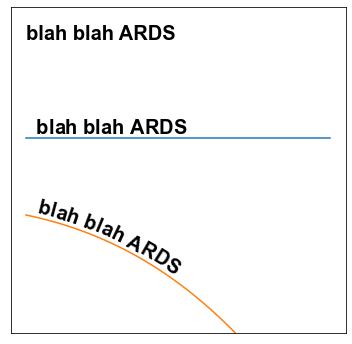

In [115]:
# from https://stackoverflow.com/questions/19353576/curved-text-rendering-in-matplotlib
class CurvedText(mpl.text.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mpl.text.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mpl.text.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height
#             print(w, h)

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
#             rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]
#             fraction = (w/2)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y]))
#             t.set_transform(mpl.transforms.Affine2D().rotate_deg_around(
#                 0,
#                 0,
# #                 -(bbox2d[1][1] - bbox2d[0][1]) / 2,
#                 degs[il]
#             ) + self.axes.transData)
#+drp)
            t.set_rotation_mode("anchor")
            t.set_rotation(degs[il])
            self.axes.add_artist(mpl.patches.Rectangle(
                [x - (bbox2d[1][0] - bbox2d[0][0]) / 2, y],
                width=bbox2d[1][0] - bbox2d[0][0],
                height=bbox2d[1][1] - bbox2d[0][1],
                fill=None,
                ec="black",
                alpha=0.0,
#                 angle=degs[il]
            ))

#             t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
#             rel_pos += w-used
            rel_pos += w

# fig, ax = plt.subplots(subplot_kw=dict(projection="polar"), figsize=(6, 6))
fig, ax = plt.subplots(figsize=(6, 6))
# ax.spines['polar'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, 5)
# ax.bar(np.pi / 2 - 1, [1], bottom=1.7, width=1, align="edge", color="salmon")
xline = np.linspace(np.pi / 2 - 1, np.pi / 2)
yline1 = 4 - xline ** 0
yline2 = 2 - xline ** 3
ax.plot(xline, yline1)
ax.plot(xline, yline2)
ax.text(np.pi / 2 - 1, 4.5, "blah blah ARDS", weight="bold", size=20,
       transform=mpl.transforms.Affine2D().rotate_around(np.pi / 2 - 1, 4.5, 1) + ax.transData)
CurvedText(
    xline,
    yline1,
    "blah blah ARDS",
    ax,
    va="bottom",
#     ha="center",
    weight="bold",
    size=20
);
CurvedText(
    xline,
    yline2,
    "blah blah ARDS",
    ax,
    va="bottom",
#     ha="center",
    weight="bold",
    size=20
);

In [116]:
df = data.copy()
last_stay_per_patient = df.groupby("patient").agg({"stay": "max"})
df["last_stay"] = last_stay_per_patient.stay[df.patient].values
df["discharge"] = df.Discharge_disposition.replace({
    "Died": "Died+Hospice",
    "Hospice": "Died+Hospice",
    "Home": "Home+Rehab",
    "Rehab": "Home+Rehab",
    "SNF": "LTACH+SNF",
    "LTACH": "LTACH+SNF"
})
df.loc[(df.next_cluster == -1) & (df.stay != df.last_stay), "discharge"] = "ICU readm."

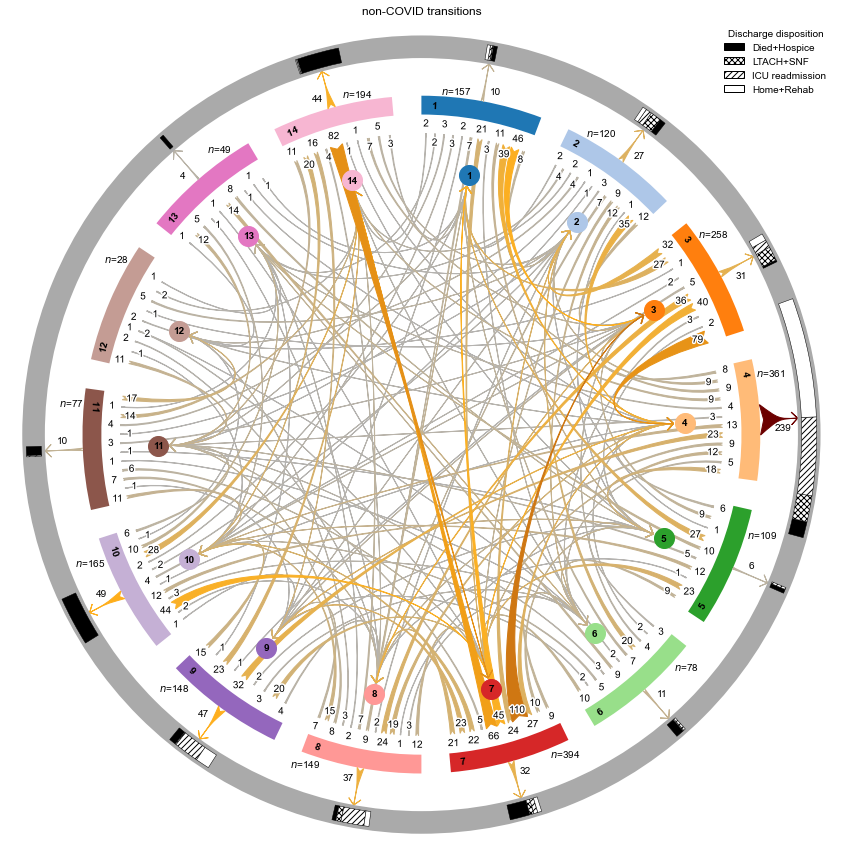

In [117]:
fig = ball_of_yarn(
    df.loc[~df.COVID_status, :], 
    pd.Series(1, index=sorted(df.cluster.unique()))
)
fig.axes[0].set_title("non-COVID transitions")
fig.tight_layout()

dump_figure('yarn_non_covid')

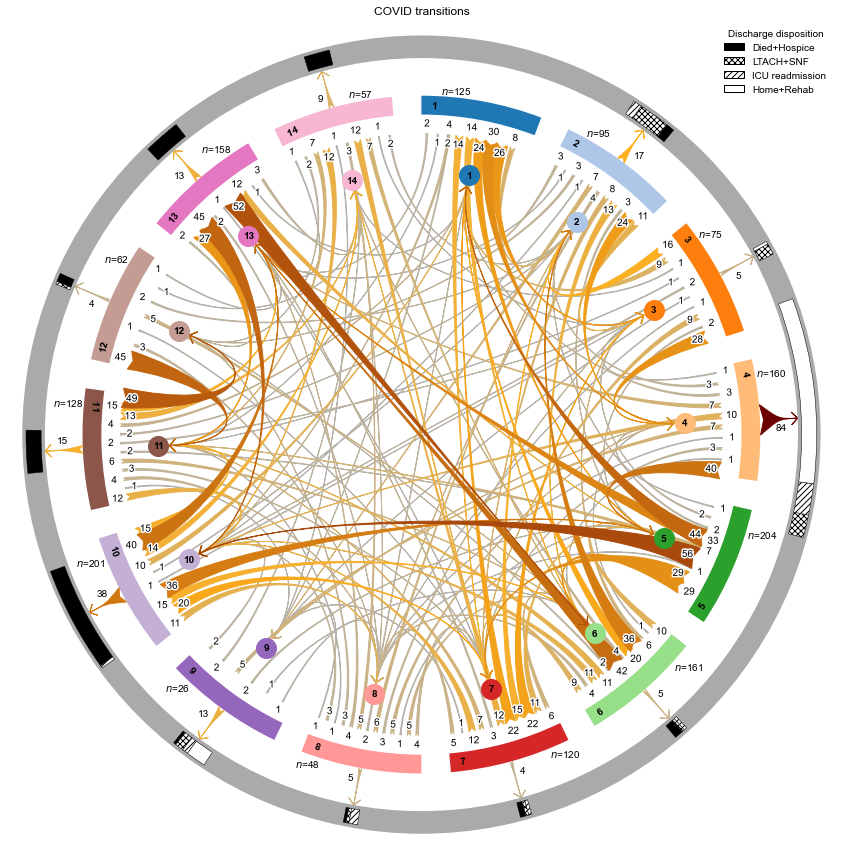

In [118]:
fig = ball_of_yarn(
    df.loc[df.COVID_status, :], 
    pd.Series(1, index=sorted(df.cluster.unique()))
)
fig.axes[0].set_title("COVID transitions")
fig.tight_layout()

dump_figure('yarn_covid')

## 3.3 Statistical tests for difference in transitions

For each cluster I compute number of transitions (including leaving ICU) into next clusters separately for COVID and non-COVID patients.

Next, I apply [chi-squared](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency) test to see if the distribution of transitions is different between COVID and non-COVID patients. As per recommendations of the test, I exclude transitions to states that have <= 5 total transitions in either group. Finally, I perform FDR correction for acquired p-values.

In [119]:
pvals = []
for c in sorted(data.cluster.unique()):
    df_covid = data.loc[
        data.COVID_status & data.cluster.eq(c) & data.next_cluster.ne(data.cluster), 
        :
    ].groupby(
        ["cluster", "next_cluster"], dropna=False
    ).agg({"day": "count"}).reset_index()
    df_covid = df_covid.loc[df_covid.cluster.eq(c), :]
    df_non_covid = data.loc[
        ~data.COVID_status & data.cluster.eq(c) & data.next_cluster.ne(data.cluster), 
        :
    ].groupby(
        ["cluster", "next_cluster"], dropna=False
    ).agg({"day": "count"}).reset_index()
    df_non_covid = df_non_covid.loc[df_non_covid.cluster.eq(c), :]
    contingency = pd.DataFrame(dict(covid=df_covid.day, non_covid=df_non_covid.day)).T
    contingency = contingency.loc[:, contingency.gt(5).sum() == 2]
    if contingency.size == 0:
        print(f"No common transitions with > 5 counts for {c}")
        continue
    res = scipy.stats.chi2_contingency(contingency, correction=False)
    pvals.append((c, res[1]))
pvals = pd.DataFrame(pvals, columns=["clinical_state", "p_value"])

No common transitions with > 5 counts for 8
No common transitions with > 5 counts for 12
No common transitions with > 5 counts for 13


In [120]:
pvals["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(pvals.p_value, alpha=0.05)[1]

In [121]:
pvals.loc[pvals.pval_adj < 0.05, :]

,clinical_state,p_value,pval_adj
0,1,2.487098e-03,6.839520e-03
3,4,1.675615e-09,1.843177e-08
4,5,9.357286e-05,5.146507e-04
6,7,1.148843e-02,2.527454e-02
8,10,2.095282e-04,7.682700e-04


For 6 out of 14 clinical states we observe statistically significant difference

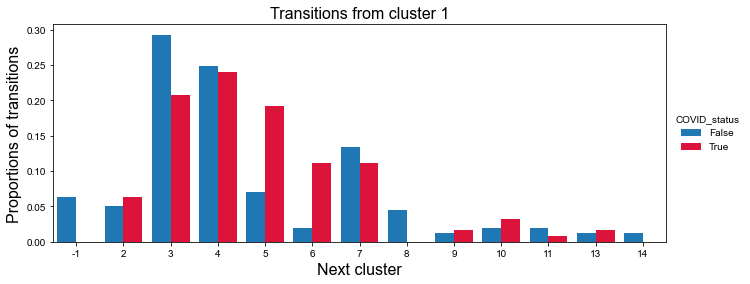

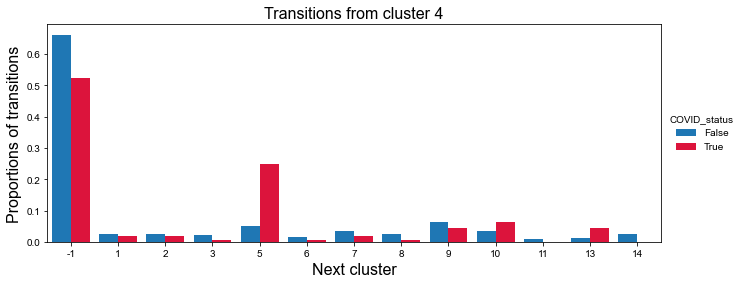

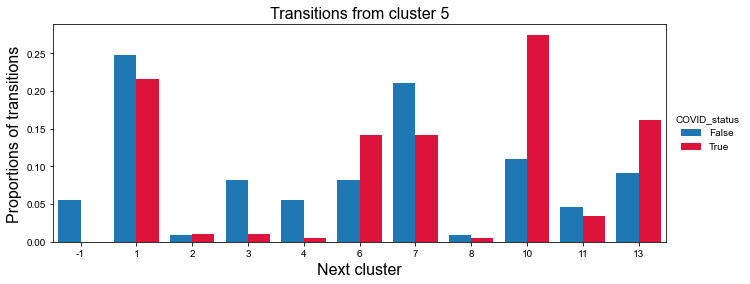

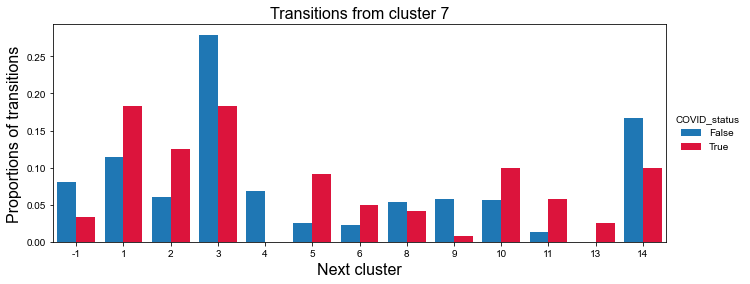

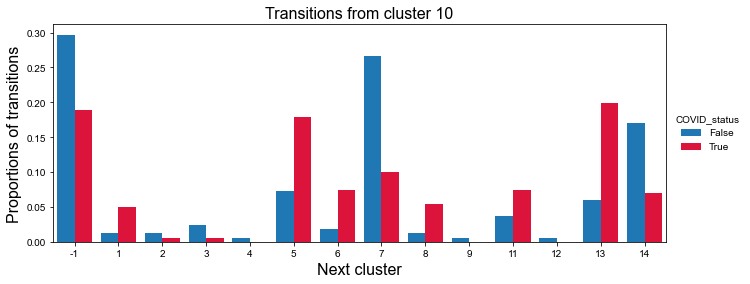

In [122]:
for c in pvals.clinical_state[pvals.pval_adj < 0.05]:
    idx = data.cluster.eq(c) & data.next_cluster.ne(c)
    fig, ax = plt.subplots(figsize=(11, 4))
    df = data.loc[idx, :].groupby(["next_cluster", "COVID_status"]).agg(
        {"day": "count"}
    ).reset_index()
    df = df.loc[df.next_cluster != c, :]
    df.loc[df.COVID_status, "day"] /= df.day[df.COVID_status].sum()
    df.loc[~df.COVID_status, "day"] /= df.day[~df.COVID_status].sum()
    sns.barplot(
        data=df,
        x="next_cluster",
        y="day",
        hue="COVID_status",
        ax=ax,
        palette=[DISCH_PALETTE[0], DISCH_PALETTE[-1]],
        saturation=1,
        linewidth=1,
    )
    ax.legend_.set_frame_on(False)
    ax.legend_._loc = 6
    ax.legend_.set_bbox_to_anchor((1, 0.5))
    ax.set_title(f"Transitions from cluster {c}", size=16)
    ax.set_ylabel("Proportions of transitions", size=16)
    ax.set_xlabel("Next cluster", size=16)
    plt.show()

In [123]:
def roll_of_yarn(df, cluster_sizes, names=None, only_show=None, threshold=0):
    if only_show is None:
        only_show = cluster_sizes.index.tolist()
    if names is None:
        names = {}
    cluster_order = cluster_sizes.index
    gap = 1
    blue_to_red = {
        "red": [
            (0.0, 62/256, 62/256),
            (1.0, 216/256, 216/256),
        ],
        "green": [
            (0.0, 109/256, 109/256),
            (1.0, 62/256, 62/256),
        ],
        "blue": [
            (0.0, 216/256, 216/256),
            (1.0, 62/256, 62/256),
        ]
    }
    mortality_cmap = mpl.colors.LinearSegmentedColormap("mort_cmaap", segmentdata=blue_to_red, N=256)
    cdict = {
        'red':   [
            (0.0, 180/256, 180/256),
            (0.2, 256/256, 256/256),
            (1.0, 108/256, 108/256)
        ],

        'green': [
            (0.0, 180/256, 180/256),
            (0.2, 176/256, 176/256),
            (1.0, 0/256, 0/256)
        ],

        'blue':  [
            (0.0, 180/256, 180/256),
            (0.2, 27/256, 27/256),
            (1.0, 0/256, 0/256)
        ]
    }
    cmap = mpl.colors.LinearSegmentedColormap('exprCmap', segmentdata=cdict, N=256)
    lw = 1.5
    fig, ax = plt.subplots(figsize=(15, 8))
    tx = get_axes_pixel_transform(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([0.4, 9.6])
    ax.set_yticklabels(["non-COVID", "COVID"], size=16)
    ax.set_ylim(0, 10.5)
    ax.set_xlim(0, cluster_sizes.cumsum().iat[-1] + gap * (cluster_sizes.size - 1))
    data = df.copy()
    
    for covid in (False, True):
        df = data.loc[data.COVID_status == covid, :]
        df = df.loc[df.cluster != df.next_cluster, :].groupby(
            ["cluster", "next_cluster"], dropna=False
        ).agg({"day": "count"}).reset_index()
        df = df.loc[df.next_cluster != -1, :]
        df = df.loc[df.day > 0, :]
        df = df.reset_index()

        start = 0
        bottom = 9.2 if covid else 0
        xticks = []
        for i, cluster_size in enumerate(cluster_sizes.tolist()):
            this_name = cluster_order[i]
            this_color = mortality_cmap(cluster_mortality.mortality[this_name])
            ax.bar(start, 0.8, bottom=bottom, width=cluster_size, align="edge", color=this_color)
            xticks.append(start + cluster_size / 2)
            if covid:
                ax.scatter([start + cluster_size / 2], [5], s=1000, color=this_color, zorder=1000)
                ax.text(start + cluster_size / 2, 5, cluster_order[i], ha="center", va="center", weight="bold", zorder=1100)
            n_text = start + cluster_size / 2
            ax.text(
                n_text, 
                9.6 if covid else 0.4, 
                f"$n$={df.day[df.cluster == this_name].sum()}", 
                ha="center", 
                va="center", 
                zorder=11
            )
            start += cluster_size + gap
        ax.set_xticks(xticks)
        ax.set_xticklabels([names.get(x, x) for x in cluster_order.tolist()])
        max_out = 0
        for i, cluster_size in enumerate(cluster_sizes.tolist()):
            this_name = cluster_order[i]
            if this_name not in only_show:
                continue
            df_slice = df.loc[df.cluster == this_name]
            df_slice = df_slice.loc[df_slice.day > threshold, :]
            if df_slice.size == 0:
                continue
            arrow_space = cluster_size / df_slice.shape[0]
            for j, (_, r) in enumerate(df_slice.iterrows()):
                r0 = 8.7 if covid else 1.25
                pct_txt = str(r.day)
                color = cmap(r.day / df.day.max())
                lw = 0.0 + 8 * (r.day / df.day.max()) ** 0.8
                t0 = 0
                if i > 0:
                    t0 += cluster_sizes.cumsum().iat[i - 1] + gap * i
                t0 += arrow_space / 2
                t0 += j * arrow_space
                next_cl = r.next_cluster
                next_cl_idx = cluster_sizes.index.get_loc(next_cl)
                next_cl_pos = 0
                if next_cl_idx > 0:
                    next_cl_pos += cluster_sizes.cumsum()[next_cl - 1] + gap * next_cl_idx
                next_cl_pos += cluster_sizes[next_cl] / 2
                t1, r1 = (next_cl_pos, 5)
                r1 -= -0.5 if covid else 0.5
                r2 = 8 if covid else 2
                r3 = 7 if covid else 3
                path = get_arrow_path(ax, tx, (t0, r0), (t0, r2), (t1, r3), (t1, r1), base_w=lw)
                patch = mpl.patches.PathPatch(
                    path, 
                    fc=color, 
                    ec=color, 
                    lw=1,
                    transform=tx,
                    zorder=r.day
                )
                ax.add_patch(patch)
                if covid:
                    text_r = r0 + 0.3
                else:
                    text_r = r0 - 0.3
                path_effects = path_effects = [
                    mpl.patheffects.Stroke(linewidth=3, foreground="white"),
                    mpl.patheffects.Normal()
                ]
                if arrow_space < 2 and j % 2 == 1:
                    text_r += -0.25 if covid else 0.25
                ax.text(t0, text_r, pct_txt, ha="center", va="center", zorder=1000, path_effects=path_effects)
    cbar_ax = fig.add_axes((0.05, 0.4, 0.02, 0.3))
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=mortality_cmap), 
        cax=cbar_ax,
    )
    cbar.set_label("Cluster mortality", size=12)
    return fig

/var/folders/5k/xnlfp9d173j8h4bx8pzcpngh0000gn/T/ipykernel_56397/2174241588.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


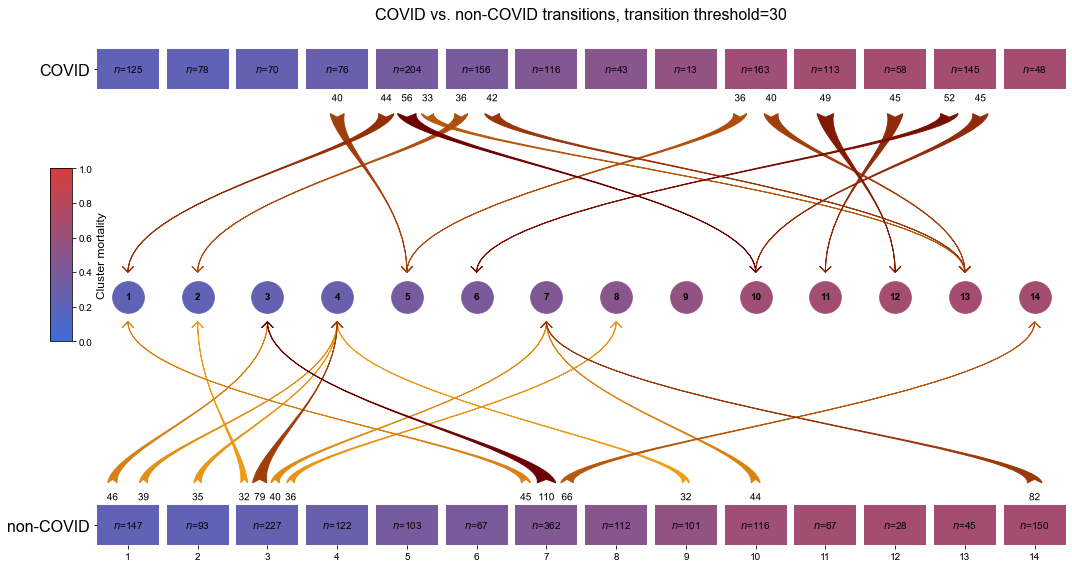

In [124]:
fig = roll_of_yarn(
    data, 
    pd.Series(8, index=sorted(data.cluster.unique())),
    threshold=30
)
fig.axes[0].set_title("COVID vs. non-COVID transitions, transition threshold=30", size=16)
fig.tight_layout()
# fig.savefig("13covid-vs-non-covid-transitions.pdf")

dump_figure('state_boxes_covid-vs-non-covid-transition')

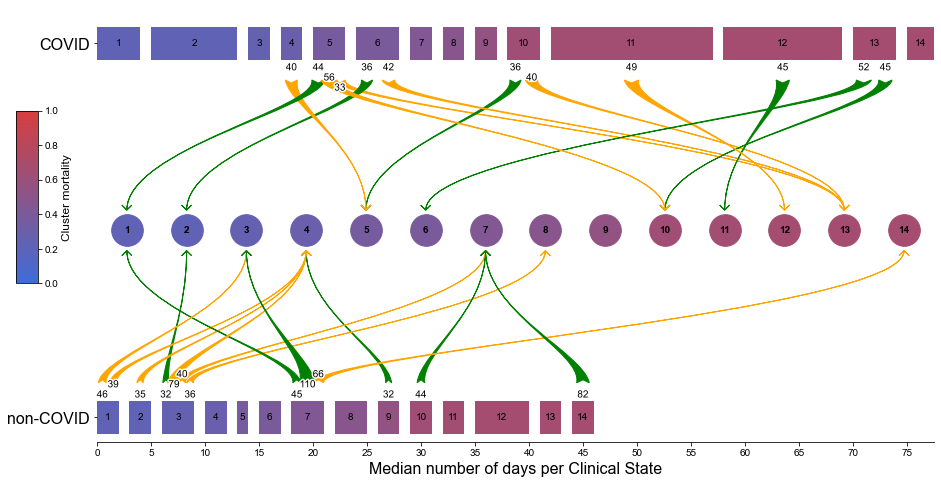

In [125]:
def roll_of_yarn2(df, cluster_sizes, names=None, only_show=None, threshold=0):
    if only_show is None:
        only_show = cluster_sizes.index.tolist()
    if names is None:
        names = {}
    cluster_order = cluster_sizes.index
    gap = 1
    blue_to_red = {
        "red": [
            (0.0, 62/256, 62/256),
            (1.0, 216/256, 216/256),
        ],
        "green": [
            (0.0, 109/256, 109/256),
            (1.0, 62/256, 62/256),
        ],
        "blue": [
            (0.0, 216/256, 216/256),
            (1.0, 62/256, 62/256),
        ]
    }
    mortality_cmap = mpl.colors.LinearSegmentedColormap("mort_cmaap", segmentdata=blue_to_red, N=256)
#     cdict = {
#         'red':   [
#             (0.0, 180/256, 180/256),
#             (0.2, 256/256, 256/256),
#             (1.0, 108/256, 108/256)
#         ],

#         'green': [
#             (0.0, 180/256, 180/256),
#             (0.2, 176/256, 176/256),
#             (1.0, 0/256, 0/256)
#         ],

#         'blue':  [
#             (0.0, 180/256, 180/256),
#             (0.2, 27/256, 27/256),
#             (1.0, 0/256, 0/256)
#         ]
#     }
    min_mortality_diff = cluster_mortality.mortality.min() - cluster_mortality.mortality.max()
    max_mortality_diff = cluster_mortality.mortality.max() - cluster_mortality.mortality.min()
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'exprCmap', 
        [DISCH_PALETTE[0], DISCH_PALETTE[-1]]
    )
    cmap = sns.cm.vlag
    lw = 1.5
    fig, ax = plt.subplots(figsize=(15, 8))
    tx = get_axes_pixel_transform(ax)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yticks([0.4, 9.6])
    ax.set_yticklabels(["non-COVID", "COVID"], size=16)
    ax.set_ylim(-0.2, 10.5)
    ax.set_xlabel("Median number of days per Clinical State", size=16)
    # ax.set_xlim(0, cluster_sizes.cumsum().iat[-1] + gap * (cluster_sizes.size - 1))
    data = df.copy()
    
    for covid in (True, False):
        df = data.loc[data.COVID_status == covid, :]
        cl_size = df.groupby(["patient", "cluster"]).agg({"day": "count"}).reset_index().groupby(
            "cluster"
        ).day.median()
            
        df = df.loc[df.is_transition, :].groupby(
            ["cluster", "next_cluster"], dropna=False
        ).agg({"day": "count"}).reset_index()
        df = df.loc[df.day > 0, :]
        df = df.reset_index()

        start = 0
        bottom = 9.2 if covid else 0
        # if not covid:
            # gap = (rightmost - cl_size.sum()) / (cl_size.size - 1)
            # start = (rightmost - cl_size.sum() - (cl_size.size - 1) * gap) / 2
            # non_covid_start = start
        # xticks = []
        for i, cluster_size in enumerate(cl_size.tolist()):
            this_name = cluster_order[i]
            this_color = mortality_cmap(cluster_mortality.mortality[this_name])
            ax.bar(start, 0.8, bottom=bottom, width=cluster_size, align="edge", color=this_color)
            # xticks.append(start + cluster_size / 2)
            # if covid:
            #     ax.scatter([start + cluster_size / 2], [5], s=1000, color=this_color, zorder=1000)
            #     ax.text(start + cluster_size / 2, 5, cluster_order[i], ha="center", va="center", weight="bold", zorder=1100)
            n_text = start + cluster_size / 2
            ax.text(
                n_text, 
                9.6 if covid else 0.4, 
                this_name, 
                ha="center", 
                va="center", 
                zorder=11
            )
            start += cluster_size + gap

        if covid:
            pad = 2
            start = 0
            rightmost = cl_size.sum() + gap * (cl_size.size - 1)
            ax.set_xlim(0, rightmost)
            sink_gap = (rightmost - start) / cl_size.size
            sink_pos = {}
            # ax.axvline(start, color="red", lw=1)
            # ax.axvline(rightmost, color="red", lw=1)
            for i, _ in enumerate(cl_size.tolist()):
                this_name = cluster_order[i]
                this_color = mortality_cmap(cluster_mortality.mortality[this_name])
                ax.scatter([start + sink_gap / 2], [5], s=1000, color=this_color, zorder=1000)
                ax.text(start + sink_gap / 2, 5, cluster_order[i], ha="center", va="center", weight="bold", zorder=1100)
                # ax.axvline(start + sink_gap / 2, color="red", lw=1)
                sink_pos[cluster_order[i]] = start + sink_gap / 2
                start += sink_gap
        # ax.set_xticks(xticks)
        # ax.set_xticklabels([names.get(x, x) for x in cluster_order.tolist()])
        
        max_out = 0
        for i, cluster_size in enumerate(cl_size.tolist()):
            this_name = cluster_order[i]
            if this_name not in only_show:
                continue
            df_slice = df.loc[df.cluster == this_name]
            df_slice = df_slice.loc[df_slice.day > threshold, :]
            if df_slice.size == 0:
                continue
            arrow_space = cluster_size / df_slice.shape[0]
            for j, (_, r) in enumerate(df_slice.iterrows()):
                r0 = 8.7 if covid else 1.25
                pct_txt = str(r.day)
                mort_diff = cluster_mortality.mortality[r.next_cluster] - cluster_mortality.mortality[r.cluster]
                # color = cmap(r.day / df.day.max())
                # color = cmap((mort_diff - min_mortality_diff) / (max_mortality_diff - min_mortality_diff))
                if mort_diff > 0:
                    color = "orange"
                else:
                    color = "green"
                lw = 0.0 + 8 * (r.day / df.day.max()) ** 0.8
                t0 = 0
                # if not covid:
                #     t0 += non_covid_start
                if i > 0:
                    t0 += cl_size.cumsum().iat[i - 1] + gap * i
                t0 += arrow_space / 2
                t0 += j * arrow_space
                next_cl = r.next_cluster
                next_cl_idx = cl_size.index.get_loc(next_cl)
                next_cl_pos = sink_pos[next_cl]
                # if next_cl_idx > 0:
                #     next_cl_pos += cluster_sizes.cumsum()[next_cl - 1] + gap * next_cl_idx
                # next_cl_pos += cluster_sizes[next_cl] / 2
                t1, r1 = (next_cl_pos, 5)
                r1 -= -0.5 if covid else 0.5
                r2 = 8 if covid else 2
                r3 = 7 if covid else 3
                path = get_arrow_path(ax, tx, (t0, r0), (t0, r2), (t1, r3), (t1, r1), base_w=lw)
                patch = mpl.patches.PathPatch(
                    path, 
                    fc=color, 
                    ec=color, 
                    lw=1,
                    transform=tx,
                    zorder=r.day
                )
                ax.add_patch(patch)
                if covid:
                    text_r = r0 + 0.3
                else:
                    text_r = r0 - 0.3
                path_effects = path_effects = [
                    mpl.patheffects.Stroke(linewidth=3, foreground="white"),
                    mpl.patheffects.Normal()
                ]
                if arrow_space < 2 and j % 3 == 1:
                    text_r += -0.25 if covid else 0.25
                if arrow_space < 2 and j % 3 == 2:
                    text_r += -0.5 if covid else 0.5
                ax.text(t0, text_r, pct_txt, ha="center", va="center", zorder=1000, path_effects=path_effects)
    ax.set_xticks(range(0, int(rightmost), 5))
    cbar_ax = fig.add_axes((0.05, 0.4, 0.02, 0.3))
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(cmap=mortality_cmap), 
        cax=cbar_ax,
    )
    cbar.set_label("Cluster mortality", size=12)
    return fig
fig = roll_of_yarn2(
    data, 
    pd.Series(8, index=sorted(data.cluster.unique())),
    threshold=30
)

dump_figure('state_boxes')